In [ ]:
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchaudio.functional import lowpass_biquad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
SAMPLE_RATE = 16000
AUDIO_LEN = 16000
BATCH_SIZE = 16
LR = 1e-3
MESSAGE_BITS = 16
EPOCHS = 10
NUM_WORKERS = 16
FINE_TUNE_EPOCHS = 3

LAMBDA_L1 = 0.1
LAMBDA_MSSPEC = 2.0
LAMBDA_LOUD = 10.0
LAMBDA_LOC = 10.0
LAMBDA_DEC = 1.0

torch.set_float32_matmul_precision('high')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
class OneSecClipsDataset(Dataset):
    def __init__(self, root_dir, sample_rate=16000):
        self.filepaths = glob.glob(os.path.join(root_dir, '**', '*.wav'), recursive=True)
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.filepaths[idx])
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        if waveform.shape[1] > AUDIO_LEN:
            waveform = waveform[:, :AUDIO_LEN]
        elif waveform.shape[1] < AUDIO_LEN:
            waveform = F.pad(waveform, (0, AUDIO_LEN - waveform.shape[1]))
        return waveform


In [ ]:
# Residual Block for 1D signals
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(ch, ch, 3, padding=1),
            nn.BatchNorm1d(ch),
            nn.ReLU(),
            nn.Conv1d(ch, ch, 3, padding=1),
            nn.BatchNorm1d(ch)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.block(x))

# Generator: Encoder -> LSTM -> (Optional) Message Embedding -> Decoder
class Generator(nn.Module):
    def __init__(self, message_bits=0):
        super().__init__()
        self.message_bits = message_bits

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, 7, padding=3),
            ResBlock(64),
            ResBlock(64)
        )
        self.lstm = nn.LSTM(64, 64, batch_first=True)

        if message_bits > 0:
            self.embedding = nn.Embedding(2 ** message_bits, 64)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 64, 7, padding=3),
            ResBlock(64),
            nn.Conv1d(64, 1, 1)
        )

    def forward(self, s, message=None):
        # s: (B, 1, T)
        x = self.encoder(s)         # (B, 64, T)
        x = x.permute(0, 2, 1)        # (B, T, 64)
        x, _ = self.lstm(x)          # (B, T, 64)
        x = x.permute(0, 2, 1)        # (B, 64, T)

        if self.message_bits > 0 and message is not None:
            # Embed message and add to every time step
            emb = self.embedding(message).unsqueeze(-1)  # (B, 64, 1)
            x = x + emb.expand_as(x)

        delta = self.decoder(x)       # (B, 1, T)
        return delta



In [ ]:
# Detector: CNN-based architecture to produce sample-level logits.
class Detector(nn.Module):
    def __init__(self, message_bits=0):
        super().__init__()
        self.message_bits = message_bits
        output_dim = 1 + message_bits

        self.model = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, padding=3),
            ResBlock(64),
            ResBlock(64),
            nn.Conv1d(64, output_dim, kernel_size=1)
        )

    def forward(self, x):
        # x: (B, 1, T)
        x = self.model(x)
        return x.permute(0, 2, 1)  # (B, T, output_dim)

In [ ]:
def perceptual_postprocess(x, cutoff=7000):
    # x : float32 in [-1,1], (B,1,T)
    y = lowpass_biquad(x, SAMPLE_RATE, cutoff_freq=cutoff)
    y = torch.round(y * 32767) / 32767.0
    return y

In [ ]:
class MultiScaleMelLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=1024, hop_length=256, n_mels=64
        )

    def forward(self, clean, watermarked):
        m1 = torch.log(self.mel(clean) + 1e-5)
        m2 = torch.log(self.mel(watermarked) + 1e-5)
        return F.l1_loss(m1, m2)

class TFLoudnessLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.win_size = 2048
        self.hop = 512

    def forward(self, clean, watermarked):
        window = torch.hann_window(self.win_size).to(clean.device)
        stft_c = torch.stft(clean.squeeze(1), self.win_size, self.hop, window=window, return_complex=True)
        stft_w = torch.stft(watermarked.squeeze(1), self.win_size, self.hop, window=window, return_complex=True)

        mask = (stft_c.abs() > 0.01).float()
        diff = (stft_w.abs() - stft_c.abs()) ** 2
        return (diff * mask).mean()


In [ ]:
def train_one_epoch(generator, detector, train_loader, optimizer, losses, device):
    generator.train()
    detector.train()
    num_batches = 0

    loss_sums = {
        "total": 0.0,
        "raw_total": 0.0,
        "l1": 0.0,
        "mel": 0.0,
        "loud": 0.0,
        "loc": 0.0,
        "bce": 0.0,
    }

    for s in tqdm(train_loader, desc="Training Epoch"):
        s = s.to(device)
        B = s.size(0)
        message = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device)
        optimizer.zero_grad()

        delta = generator(s, message)
        s_w = s + delta
        s_w = perceptual_postprocess(s_w) 
        combined = torch.cat([s_w, s], dim=0)
        logits = detector(combined)

        detection_logits = logits[:, :, 0]
        decode_logits = logits[:B, :, 1:]

        target_detection = torch.cat([
            torch.ones(B, s.shape[-1], device=device),
            torch.zeros(B, s.shape[-1], device=device)
        ], dim=0)

        loc_loss = F.binary_cross_entropy_with_logits(detection_logits, target_detection)
        bitmask = (1 << torch.arange(MESSAGE_BITS, device=device))
        target_bits = ((message.unsqueeze(1) & bitmask) > 0).float()
        target_bits = target_bits.unsqueeze(1).expand(-1, s.shape[-1], -1)
        bce = F.binary_cross_entropy_with_logits(decode_logits, target_bits)

        l1 = F.l1_loss(delta, torch.zeros_like(delta))
        mel = losses["mel"](s, s_w)
        loud = losses["loud"](s, s_w)
        raw_loss = l1 + mel + loud + loc_loss + bce
        loss = (LAMBDA_L1 * l1 + LAMBDA_MSSPEC * mel + LAMBDA_LOUD * loud +
                LAMBDA_LOC * loc_loss + LAMBDA_DEC * bce)
        loss.backward()
        optimizer.step()

        # Accumulate loss components
        loss_sums["total"] += loss.item()
        loss_sums["raw_total"] += raw_loss.item()
        loss_sums["l1"] += l1.item()
        loss_sums["mel"] += mel.item()
        loss_sums["loud"] += loud.item()
        loss_sums["loc"] += loc_loss.item()
        loss_sums["bce"] += bce.item()

        num_batches += 1

    for key in loss_sums:
        loss_sums[key] /= num_batches

    return loss_sums


def validate_one_epoch(generator, detector, val_loader, losses, device):
    generator.eval()
    detector.eval()

    num_batches = 0
    loss_sums = {
        "total": 0.0,
        "raw_total": 0.0,
        "l1": 0.0,
        "mel": 0.0,
        "loud": 0.0,
        "loc": 0.0,
        "bce": 0.0,
    }


    with torch.no_grad():
        for s in tqdm(val_loader, desc="Validation Epoch"):
            s = s.to(device)
            B = s.size(0)
            message = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device)

            delta = generator(s, message)
            s_w = s + delta
            s_w = perceptual_postprocess(s_w) 
            combined = torch.cat([s_w, s], dim=0)
            logits = detector(combined)

            detection_logits = logits[:, :, 0]
            decode_logits = logits[:B, :, 1:]

            target_detection = torch.cat([
                torch.ones(B, s.shape[-1], device=device),
                torch.zeros(B, s.shape[-1], device=device)
            ], dim=0)

            loc_loss = F.binary_cross_entropy_with_logits(detection_logits, target_detection)
            bitmask = (1 << torch.arange(MESSAGE_BITS, device=device))
            target_bits = ((message.unsqueeze(1) & bitmask) > 0).float()
            target_bits = target_bits.unsqueeze(1).expand(-1, s.shape[-1], -1)
            bce = F.binary_cross_entropy_with_logits(decode_logits, target_bits)

            l1 = F.l1_loss(delta, torch.zeros_like(delta))
            mel = losses["mel"](s, s_w)
            loud = losses["loud"](s, s_w)
            raw_val_loss = l1 + mel + loud + loc_loss + bce
            loss_val = (LAMBDA_L1 * l1 + LAMBDA_MSSPEC * mel + LAMBDA_LOUD * loud +
                        LAMBDA_LOC * loc_loss + LAMBDA_DEC * bce)

            # Accumulate loss components
            loss_sums["total"] += loss_val.item()
            loss_sums["raw_total"] += raw_val_loss.item()
            loss_sums["l1"] += l1.item()
            loss_sums["mel"] += mel.item()
            loss_sums["loud"] += loud.item()
            loss_sums["loc"] += loc_loss.item()
            loss_sums["bce"] += bce.item()

            num_batches += 1

    for key in loss_sums:
        loss_sums[key] /= num_batches

    return loss_sums


In [ ]:
def evaluate_model(generator, detector, dataloader, device, threshold=0.5):
    generator.eval()
    detector.eval()
    all_probs_real = []
    all_probs_watermarked = []
    bit_accs = []
    rms_deltas = []

    with torch.no_grad():
        for s in tqdm(dataloader, desc="Evaluating"):
            s = s.to(device)
            B = s.size(0)
            message = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device)

            delta = generator(s, message)
            s_w = s + delta
            combined_audio = torch.cat([s_w, s], dim=0)
            logits = detector(combined_audio)
            detection_logits = logits[:, :, 0]
            decoded_logits = logits[:, :, 1:]

            avg_probs = torch.sigmoid(detection_logits).mean(dim=1)
            all_probs_watermarked.extend(avg_probs[:B].cpu().numpy())
            all_probs_real.extend(avg_probs[B:].cpu().numpy())

            # Bit decoding via majority vote along time dimension
            decoded_bits = (torch.sigmoid(decoded_logits[:B]) > 0.5).float().mean(dim=1) > 0.5
            bit_targets = ((message.unsqueeze(1) & (1 << torch.arange(MESSAGE_BITS, device=device))) > 0).float()
            acc = (decoded_bits == bit_targets).float().mean(dim=1)
            bit_accs.extend(acc.cpu().numpy())

            rms = torch.sqrt((delta ** 2).mean(dim=[1, 2]))
            rms_deltas.extend(rms.cpu().numpy())


    avg_real = np.mean(all_probs_real)
    avg_watermarked = np.mean(all_probs_watermarked)
    avg_bit_acc = np.mean(bit_accs)
    avg_rms = np.mean(rms_deltas)

    print("\nEvaluation Results:")
    print(f"  Avg Detection Prob - Watermarked: {avg_watermarked:.4f}")
    print(f"  Avg Detection Prob - Clean:       {avg_real:.4f}")
    print(f"  Avg Bit Attribution Accuracy:     {avg_bit_acc:.4f}")
    print(f"  Avg Watermark RMS:                {avg_rms:.6f}")

    return {
        "watermarked_prob": avg_watermarked,
        "clean_prob": avg_real,
        "bit_accuracy": avg_bit_acc,
        "delta_rms": avg_rms
    }


In [ ]:
def visualize_delta(generator, dataset, device, num_examples=3):
    loader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True)
    generator.eval()
    for i, s in enumerate(loader):
        if i >= num_examples:
            break
        s = s.to(device)
        with torch.no_grad():
            delta = generator(s)
        s_orig = s.cpu().squeeze().numpy()
        s_w = (s + delta).cpu().squeeze().numpy()
        plt.figure(figsize=(12, 3))
        plt.plot(s_orig, label="Original")
        plt.plot(s_w, label="Watermarked")
        plt.title("Waveform: Original vs. Watermarked")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()

In [ ]:
full_dataset = OneSecClipsDataset(root_dir="data/200_speech_only", sample_rate=SAMPLE_RATE)


# # Split: 80% train, 20% val
n = len(full_dataset)
n_train = int(0.8 * n)
n_val   = int(0.2 * n)

train_dataset, val_dataset = random_split(full_dataset, [n_train, n_val])
print(f"Dataset split => Train: {len(train_dataset)}, Val: {len(val_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)




Dataset split => Train: 306964, Val: 76741


In [ ]:
# full_dataset = OneSecClipsDataset(root_dir="data/200_speech_only", sample_rate=SAMPLE_RATE)

# subset_dataset = Subset(full_dataset, range(0, 10000))
# print(f"Subset dataset size: {len(subset_dataset)}")
# # # # Split: 80% train, 20% val
# n = len(subset_dataset)
# n_train = int(0.8 * n)
# n_val   = int(0.2 * n)
# train_dataset, val_dataset = random_split(subset_dataset, [n_train, n_val])
# print(f"Dataset split => Train: {len(train_dataset)}, Val: {len(val_dataset)}")
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
# val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)





In [ ]:
generator = Generator(message_bits=MESSAGE_BITS).to(device)
detector = Detector(message_bits=MESSAGE_BITS).to(device)

generator = torch.compile(generator)
detector = torch.compile(detector)

losses = {  
    "mel": MultiScaleMelLoss().to(device),
    "loud": TFLoudnessLoss().to(device)
}
optimizer = torch.optim.Adam(list(generator.parameters()) + list(detector.parameters()), lr=LR)



In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def step(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, min_delta=0.001)

In [ ]:
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key[len(prefix):] if key.startswith(prefix) else key
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict, strict=False)


In [ ]:
# ─── model instantiation ─────────────────────────────────────────────────────
generator = Generator(message_bits=MESSAGE_BITS).to(device)
detector  = Detector(message_bits=MESSAGE_BITS).to(device)

# ─── load pretrained weights ──────────────────────────────────────────────────

generator_state = torch.load("generator_best.pth", map_location=device)  
detector_state = torch.load("detector_best.pth", map_location=device)
load_state_dict_strip_prefix(generator, generator_state, prefix="_orig_mod.")
load_state_dict_strip_prefix(detector, detector_state, prefix="_orig_mod.")

# ─── set up optimizer for fine-tuning ────────────────────────────────────────
#   both models, but at a much lower LR
optimizer = torch.optim.Adam(
    list(generator.parameters()) + list(detector.parameters()),
    lr=1e-5
)


/tmp/ipykernel_28989/4215717589.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_state = torch.load("generator_best.pth", map_location=device)
/tmp/ipykernel_28

In [ ]:
best_val = float('inf')
for epoch in range(1, FINE_TUNE_EPOCHS + 1):
    train_m = train_one_epoch(generator, detector, train_loader, optimizer, losses, device)
    val_m   = validate_one_epoch(generator, detector, val_loader,   losses, device)

    print(f"Epoch {epoch}: train={train_m['total']:.4f}, val={val_m['total']:.4f}")
    if val_m["total"] < best_val:
        best_val = val_m["total"]
        torch.save(generator.state_dict(), "generator_ft.pth")
        torch.save(detector.state_dict(),  "detector_ft.pth")


Training Epoch:  96%|█████████▌| 18403/19186 [55:35<02:21,  5.51it/s]

In [ ]:
# train_logs = []
# val_logs = []


# best_val_loss = float('inf')
# for epoch in range(1, EPOCHS + 1):
#     train_metrics = train_one_epoch(generator, detector, train_loader, optimizer, losses, device)
#     val_metrics = validate_one_epoch(generator, detector, val_loader, losses, device)

#     train_logs.append(train_metrics)
#     val_logs.append(val_metrics)

#     print(f"Epoch {epoch}:")
#     for key in train_metrics:
#         print(f"  [Train] {key}: {train_metrics[key]:.4f} | [Val] {val_metrics[key]:.4f}")

#     # Save best model
#     if val_metrics["total"] < best_val_loss:
#         best_val_loss = val_metrics["total"]
#         torch.save(generator.state_dict(), "generator_best.pth")
#         torch.save(detector.state_dict(), "detector_best.pth")
#         print("Saved best model")
        
#     early_stopping.step(val_metrics["total"])
#     if early_stopping.early_stop:
#         print("Early stopping triggered")
#         break    
        


Validation Epoch: 100%|██████████| 125/125 [00:05<00:00, 21.61it/s]


Epoch 1:
  [Train] total: 123.2593 | [Val] 17.4060
  [Train] raw_total: 14.4504 | [Val] 3.4728
  [Train] l1: 0.0666 | [Val] 0.0255
  [Train] mel: 1.7850 | [Val] 1.3503
  [Train] loud: 11.3491 | [Val] 0.8187
  [Train] loc: 0.5491 | [Val] 0.5819
  [Train] bce: 0.7005 | [Val] 0.6964
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:04<00:00, 25.34it/s]


Epoch 2:
  [Train] total: 14.1844 | [Val] 10.8638
  [Train] raw_total: 2.9072 | [Val] 2.3355
  [Train] l1: 0.0198 | [Val] 0.0129
  [Train] mel: 1.0535 | [Val] 0.7630
  [Train] loud: 0.5223 | [Val] 0.2289
  [Train] loc: 0.6156 | [Val] 0.6352
  [Train] bce: 0.6961 | [Val] 0.6955
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:04<00:00, 25.37it/s]


Epoch 3:
  [Train] total: 10.1782 | [Val] 9.1987
  [Train] raw_total: 2.1555 | [Val] 1.8925
  [Train] l1: 0.0110 | [Val] 0.0084
  [Train] mel: 0.6263 | [Val] 0.4233
  [Train] loud: 0.1772 | [Val] 0.1110
  [Train] loc: 0.6457 | [Val] 0.6546
  [Train] bce: 0.6953 | [Val] 0.6952
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:04<00:00, 25.47it/s]


Epoch 4:
  [Train] total: 8.9539 | [Val] 8.4148
  [Train] raw_total: 1.8275 | [Val] 1.7450
  [Train] l1: 0.0096 | [Val] 0.0085
  [Train] mel: 0.3714 | [Val] 0.3369
  [Train] loud: 0.1437 | [Val] 0.0927
  [Train] loc: 0.6079 | [Val] 0.6118
  [Train] bce: 0.6950 | [Val] 0.6951
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:04<00:00, 25.22it/s]


Epoch 5:
  [Train] total: 8.3184 | [Val] 7.8558
  [Train] raw_total: 1.8068 | [Val] 1.7140
  [Train] l1: 0.0097 | [Val] 0.0072
  [Train] mel: 0.4252 | [Val] 0.3704
  [Train] loud: 0.1161 | [Val] 0.0552
  [Train] loc: 0.5611 | [Val] 0.5868
  [Train] bce: 0.6947 | [Val] 0.6944
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:04<00:00, 25.43it/s]


Epoch 6:
  [Train] total: 7.6958 | [Val] 7.5604
  [Train] raw_total: 1.6321 | [Val] 1.5264
  [Train] l1: 0.0086 | [Val] 0.0095
  [Train] mel: 0.2864 | [Val] 0.1705
  [Train] loud: 0.0851 | [Val] 0.1061
  [Train] loc: 0.5577 | [Val] 0.5463
  [Train] bce: 0.6944 | [Val] 0.6940
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:04<00:00, 25.58it/s]


Epoch 7:
  [Train] total: 10.7312 | [Val] 7.4547
  [Train] raw_total: 1.8664 | [Val] 1.4731
  [Train] l1: 0.0110 | [Val] 0.0088
  [Train] mel: 0.1964 | [Val] 0.1179
  [Train] loud: 0.3605 | [Val] 0.0956
  [Train] loc: 0.6038 | [Val] 0.5568
  [Train] bce: 0.6947 | [Val] 0.6940
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:04<00:00, 25.63it/s]


Epoch 8:
  [Train] total: 7.0664 | [Val] 7.2484
  [Train] raw_total: 1.4245 | [Val] 1.4343
  [Train] l1: 0.0068 | [Val] 0.0068
  [Train] mel: 0.1079 | [Val] 0.0978
  [Train] loud: 0.0587 | [Val] 0.0595
  [Train] loc: 0.5569 | [Val] 0.5763
  [Train] bce: 0.6942 | [Val] 0.6939
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:04<00:00, 25.44it/s]


Epoch 9:
  [Train] total: 6.8729 | [Val] 6.8951
  [Train] raw_total: 1.3908 | [Val] 1.3950
  [Train] l1: 0.0062 | [Val] 0.0072
  [Train] mel: 0.0907 | [Val] 0.0924
  [Train] loud: 0.0516 | [Val] 0.0712
  [Train] loc: 0.5481 | [Val] 0.5304
  [Train] bce: 0.6941 | [Val] 0.6938
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:04<00:00, 25.70it/s]

Epoch 10:
  [Train] total: 6.7786 | [Val] 6.8723
  [Train] raw_total: 1.3756 | [Val] 1.3845
  [Train] l1: 0.0060 | [Val] 0.0062
  [Train] mel: 0.0839 | [Val] 0.0837
  [Train] loud: 0.0490 | [Val] 0.0523
  [Train] loc: 0.5426 | [Val] 0.5488
  [Train] bce: 0.6941 | [Val] 0.6935
Saved best model


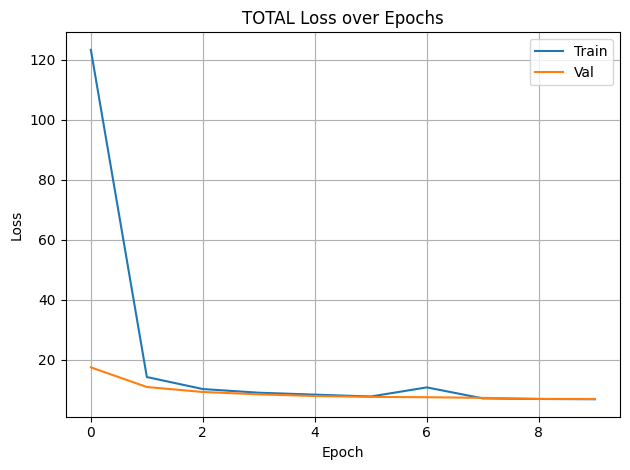

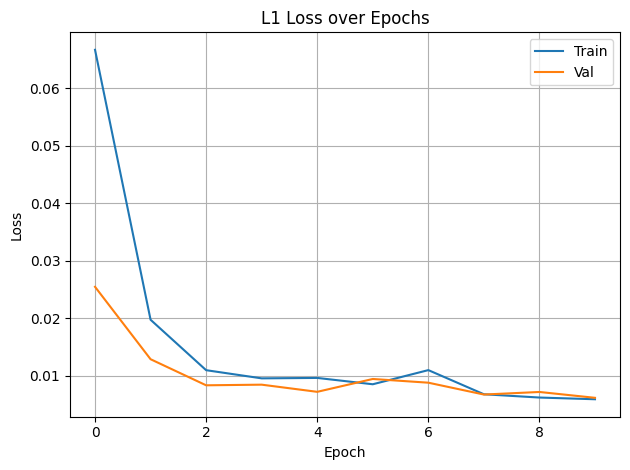

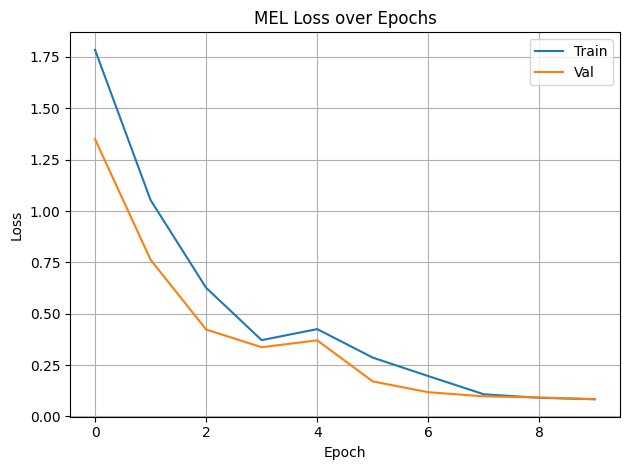

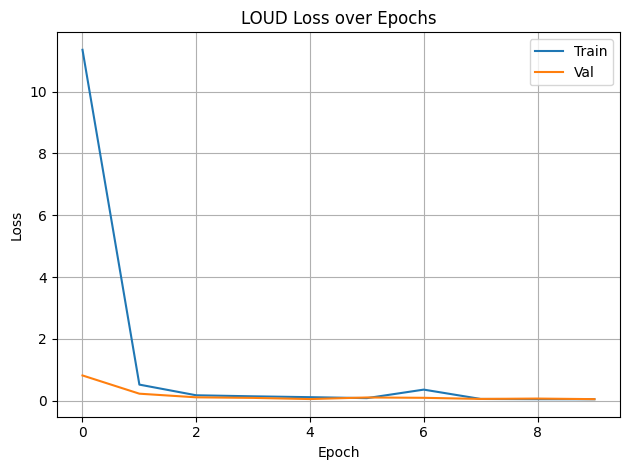

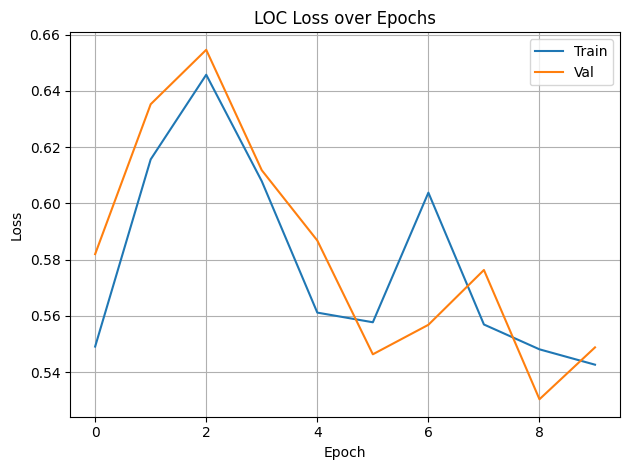

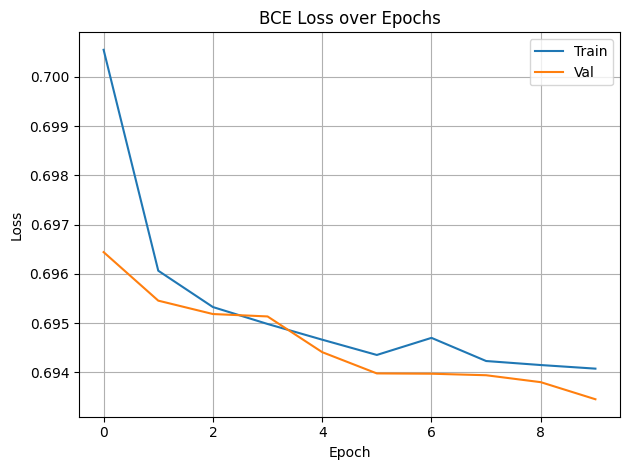

In [ ]:
keys = ["total", "l1", "mel", "loud", "loc", "bce"]

for key in keys:
    plt.figure()
    plt.plot([log[key] for log in train_logs], label="Train")
    plt.plot([log[key] for log in val_logs], label="Val")
    plt.title(f"{key.upper()} Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, classification_report

# def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
#     plt.figure(figsize=(8, 6))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(class_names))
#     plt.xticks(tick_marks, class_names, rotation=45)
#     plt.yticks(tick_marks, class_names)

#     fmt = 'd'
#     thresh = cm.max() / 2.0
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             plt.text(j, i, format(cm[i, j], fmt),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()
#     plt.show()

# def evaluate_classifier(generator, detector, dataloader, device, threshold=0.5):
#     generator.eval()
#     detector.eval()

#     y_true = []
#     y_pred = []
#     with torch.no_grad():
#         for s in tqdm(dataloader, desc="Evaluating"):
#             s = s.to(device)
#             B = s.size(0)
#             message = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device)
#             delta = generator(s, message)
#             s_w = s + delta

#             combined = torch.cat([s_w, s], dim=0)
#             labels = np.concatenate([np.ones(B), np.zeros(B)], axis=0)

#             logits = detector(combined)
#             detection_logits = logits[:, :, 0] 
#             probs = torch.sigmoid(detection_logits).mean(dim=1).cpu().numpy()
#             preds = (probs >= threshold).astype(int)

#             y_true.extend(labels)
#             y_pred.extend(preds)
    
#     cm = confusion_matrix(y_true, y_pred)
#     report = classification_report(y_true, y_pred, target_names=["Clean (0)", "Watermarked (1)"])
    
#     print("Classification Report:")
#     print(report)
    
#     class_names = ["Clean (0)", "Watermarked (1)"]
#     plot_confusion_matrix(cm, class_names, title="Confusion Matrix Heatmap")
    
#     return cm, report
# cm, report = evaluate_classifier(generator, detector, test_loader, device, threshold=0.5)


In [ ]:
# from sklearn.metrics import confusion_matrix

# def evaluate_classifier(generator, detector, dataloader, device, threshold=0.5):
#     generator.eval()
#     detector.eval()

#     y_true = []
#     y_pred = []
#     with torch.no_grad():
#         for s in tqdm(dataloader, desc="Evaluating"):
#             s = s.to(device)
#             B = s.size(0)
#             # Generate random messages for watermarked examples
#             message = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device)
#             # Generate watermarked audio
#             delta = generator(s, message)
#             s_w = s + delta

#             # Prepare a combined batch:
#             # First half: watermarked (label = 1), Second half: original clean audio (label = 0)
#             combined = torch.cat([s_w, s], dim=0)
#             labels = np.concatenate([np.ones(B), np.zeros(B)], axis=0)

#             logits = detector(combined)
#             detection_logits = logits[:, :, 0] 
#             probs = torch.sigmoid(detection_logits).mean(dim=1).cpu().numpy()

#             preds = (probs >= threshold).astype(int)

#             y_true.extend(labels)
#             y_pred.extend(preds)
    
#     cm = confusion_matrix(y_true, y_pred)
    
#     print("Confusion Matrix:")
#     print(cm)
    
#     return cm
# cm, report = evaluate_classifier(generator, detector, test_loader, device, threshold=0.5)


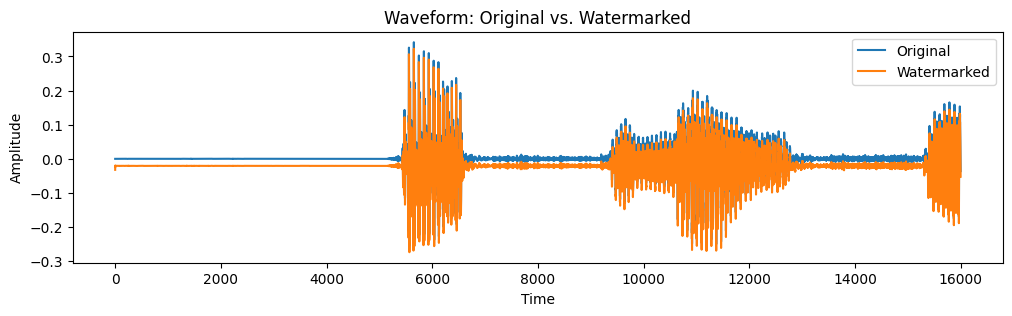

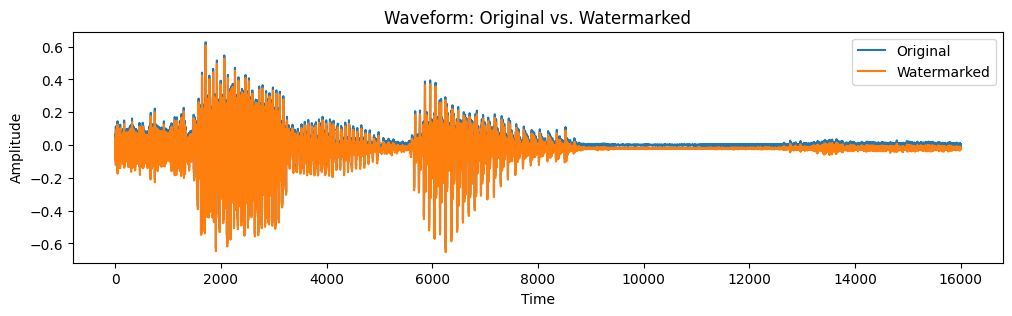

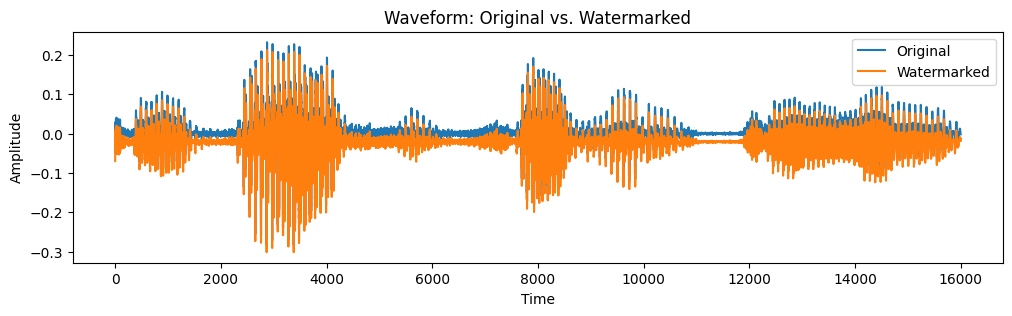

In [ ]:

if __name__ == "__main__":
    visualize_delta(generator, val_dataset, device, num_examples=3)

In [ ]:
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key[len(prefix):] if key.startswith(prefix) else key
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict, strict=False)


def load_audio(file_path, sample_rate=SAMPLE_RATE):
    waveform, sr = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    return waveform

def process_audio_file_with_delta(file_path, generator, sample_rate=SAMPLE_RATE, message_bits=MESSAGE_BITS):

    waveform = load_audio(file_path, sample_rate)  
    total_samples = waveform.shape[1]
    seg_len = sample_rate  
    num_full = total_samples // seg_len
    remainder = total_samples % seg_len

    watermarked_segments = []
    delta_segments = []
    
    generator.eval()
    with torch.no_grad():
        for i in range(num_full):
            start = i * seg_len
            end = start + seg_len
            seg = waveform[:, start:end]  
            seg = seg.to(device)
            message = torch.randint(0, 2 ** message_bits, (1,), device=device)
            seg = seg.unsqueeze(0)  
            delta_seg = generator(seg, message)  
            watermarked_seg = seg + delta_seg       
            watermarked_segments.append(watermarked_seg.squeeze(0).cpu())
            delta_segments.append(delta_seg.squeeze(0).cpu())
        if remainder > 0:
            seg = waveform[:, num_full * seg_len:]
            padded_seg = F.pad(seg, (0, seg_len - seg.shape[1]))
            padded_seg = padded_seg.to(device)
            message = torch.randint(0, 2 ** message_bits, (1,), device=device)
            padded_seg = padded_seg.unsqueeze(0)
            delta_seg = generator(padded_seg, message)
            watermarked_seg = padded_seg + delta_seg
            watermarked_seg = watermarked_seg.squeeze(0).cpu()[:, :remainder]
            delta_seg = delta_seg.squeeze(0).cpu()[:, :remainder]
            watermarked_segments.append(watermarked_seg)
            delta_segments.append(delta_seg)
    
    watermarked_waveform = torch.cat(watermarked_segments, dim=1)  
    delta_waveform = torch.cat(delta_segments, dim=1)              
    return watermarked_waveform, delta_waveform, waveform

def compute_si_snr(s, s_hat, eps=1e-8):
    s = s - s.mean(dim=1, keepdim=True)
    s_hat = s_hat - s_hat.mean(dim=1, keepdim=True)
    dot = torch.sum(s * s_hat, dim=1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=1, keepdim=True)
    alpha = dot / (norm_s + eps)
    s_target = alpha * s
    e_noise = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=1) / (torch.sum(e_noise ** 2, dim=1) + eps))
    return si_snr.mean().item()

def run_inference_on_file(file_path, generator, detector):

    watermarked_waveform, delta_waveform, original_waveform = process_audio_file_with_delta(
        file_path, generator, sample_rate=SAMPLE_RATE, message_bits=MESSAGE_BITS
    )
    
    if watermarked_waveform.dim() == 3:
        watermarked_waveform = watermarked_waveform.squeeze(0)
    if watermarked_waveform.dim() == 2:
        input_for_detector = watermarked_waveform.unsqueeze(0)
    else:
        input_for_detector = watermarked_waveform
    input_for_detector = input_for_detector.to(device)
    
    with torch.no_grad():
        logits = detector(input_for_detector)  
        detection_logits = logits[:, :, 0]     
        detection_prob = torch.sigmoid(detection_logits).mean().item()
    
    if delta_waveform.dim() == 3:
        delta_waveform = delta_waveform.squeeze(0)
    watermark_rms = torch.sqrt((delta_waveform ** 2).mean()).item()
    
    si_snr_val = compute_si_snr(original_waveform, watermarked_waveform)
    
    return watermarked_waveform, detection_prob, watermark_rms, si_snr_val

def save_audio(waveform, output_path, sample_rate=SAMPLE_RATE):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    torchaudio.save(output_path, waveform, sample_rate)

generator = Generator(message_bits=MESSAGE_BITS).to(device)
detector = Detector(message_bits=MESSAGE_BITS).to(device)
generator_state = torch.load("generator_best.pth", map_location=device)  
detector_state = torch.load("detector_best.pth", map_location=device)
load_state_dict_strip_prefix(generator, generator_state, prefix="_orig_mod.")
load_state_dict_strip_prefix(detector, detector_state, prefix="_orig_mod.")
generator.eval()
detector.eval()

input_file = "file_example_WAV_2MG.wav" 
output_file = "inference_results/your_audio_file_watermarked.wav" 

watermarked, det_prob, rms_val, si_snr_val = run_inference_on_file(input_file, generator, detector)
print(f"Detection Probability: {det_prob:.4f}")
print(f"Watermark RMS: {rms_val:.6f}")
print(f"SI-SNR: {si_snr_val:.2f} dB")

if watermarked.dim() == 3:
    watermarked = watermarked.squeeze(0)

save_audio(watermarked.cpu(), output_file, sample_rate=SAMPLE_RATE)
print(f"Watermarked audio saved to: {output_file}")


/tmp/ipykernel_16829/2273396672.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_state = torch.load("generator_best.pth", map_location=device)
/tmp/ipykernel_

Detection Probability: 1.0000
Watermark RMS: 0.007758
SI-SNR: 19.94 dB
Watermarked audio saved to: inference_results/your_audio_file_watermarked.wav


In [ ]:
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key[len(prefix):] if key.startswith(prefix) else key
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict, strict=False)


def load_audio(file_path, sample_rate=SAMPLE_RATE):
    waveform, sr = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    return waveform

def process_audio_file_with_delta(file_path, generator, sample_rate=SAMPLE_RATE, message_bits=MESSAGE_BITS):

    waveform = load_audio(file_path, sample_rate)  
    total_samples = waveform.shape[1]
    seg_len = sample_rate  
    num_full = total_samples // seg_len
    remainder = total_samples % seg_len

    watermarked_segments = []
    delta_segments = []
    
    generator.eval()
    with torch.no_grad():
        for i in range(num_full):
            start = i * seg_len
            end = start + seg_len
            seg = waveform[:, start:end]  
            seg = seg.to(device)
            message = torch.randint(0, 2 ** message_bits, (1,), device=device)
            seg = seg.unsqueeze(0)  
            delta_seg = generator(seg, message)  
            watermarked_seg = seg + delta_seg       
            watermarked_segments.append(watermarked_seg.squeeze(0).cpu())
            delta_segments.append(delta_seg.squeeze(0).cpu())
        if remainder > 0:
            seg = waveform[:, num_full * seg_len:]
            padded_seg = F.pad(seg, (0, seg_len - seg.shape[1]))
            padded_seg = padded_seg.to(device)
            message = torch.randint(0, 2 ** message_bits, (1,), device=device)
            padded_seg = padded_seg.unsqueeze(0)
            delta_seg = generator(padded_seg, message)
            watermarked_seg = padded_seg + delta_seg
            watermarked_seg = watermarked_seg.squeeze(0).cpu()[:, :remainder]
            delta_seg = delta_seg.squeeze(0).cpu()[:, :remainder]
            watermarked_segments.append(watermarked_seg)
            delta_segments.append(delta_seg)
    
    watermarked_waveform = torch.cat(watermarked_segments, dim=1)  
    delta_waveform = torch.cat(delta_segments, dim=1)              
    return watermarked_waveform, delta_waveform, waveform

def compute_si_snr(s, s_hat, eps=1e-8):
    s = s - s.mean(dim=1, keepdim=True)
    s_hat = s_hat - s_hat.mean(dim=1, keepdim=True)
    dot = torch.sum(s * s_hat, dim=1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=1, keepdim=True)
    alpha = dot / (norm_s + eps)
    s_target = alpha * s
    e_noise = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=1) / (torch.sum(e_noise ** 2, dim=1) + eps))
    return si_snr.mean().item()

def run_inference_on_file(file_path, generator, detector):

    watermarked_waveform, delta_waveform, original_waveform = process_audio_file_with_delta(
        file_path, generator, sample_rate=SAMPLE_RATE, message_bits=MESSAGE_BITS
    )
    
    if watermarked_waveform.dim() == 3:
        watermarked_waveform = watermarked_waveform.squeeze(0)
    if watermarked_waveform.dim() == 2:
        input_for_detector = watermarked_waveform.unsqueeze(0)
    else:
        input_for_detector = watermarked_waveform
    input_for_detector = input_for_detector.to(device)
    
    with torch.no_grad():
        logits = detector(input_for_detector)  
        detection_logits = logits[:, :, 0]     
        detection_prob = torch.sigmoid(detection_logits).mean().item()
    
    if delta_waveform.dim() == 3:
        delta_waveform = delta_waveform.squeeze(0)
    watermark_rms = torch.sqrt((delta_waveform ** 2).mean()).item()
    
    si_snr_val = compute_si_snr(original_waveform, watermarked_waveform)
    
    return watermarked_waveform, detection_prob, watermark_rms, si_snr_val

def save_audio(waveform, output_path, sample_rate=SAMPLE_RATE):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    torchaudio.save(output_path, waveform, sample_rate)

generator = Generator(message_bits=MESSAGE_BITS).to(device)
detector = Detector(message_bits=MESSAGE_BITS).to(device)
generator_state = torch.load("generator_best.pth", map_location=device)  
detector_state = torch.load("detector_best.pth", map_location=device)
load_state_dict_strip_prefix(generator, generator_state, prefix="_orig_mod.")
load_state_dict_strip_prefix(detector, detector_state, prefix="_orig_mod.")
generator.eval()
detector.eval()

input_file = "Songs/Kanye West - Flashing Lights (Alternate Intro).mp3" 
output_file = "inference_results/why_watermarked.wav" 

watermarked, det_prob, rms_val, si_snr_val = run_inference_on_file(input_file, generator, detector)
print(f"Detection Probability: {det_prob:.4f}")
print(f"Watermark RMS: {rms_val:.6f}")
print(f"SI-SNR: {si_snr_val:.2f} dB")

if watermarked.dim() == 3:
    watermarked = watermarked.squeeze(0)

save_audio(watermarked.cpu(), output_file, sample_rate=SAMPLE_RATE)
print(f"Watermarked audio saved to: {output_file}")


/tmp/ipykernel_16829/3032383114.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_state = torch.load("generator_best.pth", map_location=device)
/tmp/ipykernel_

Detection Probability: 0.8699
Watermark RMS: 0.007782
SI-SNR: 29.75 dB
Watermarked audio saved to: inference_results/why_watermarked.wav


In [ ]:
generator_state = torch.load("best_models/generator_best.pth", map_location=device)  
detector_state = torch.load("best_models/detector_best.pth", map_location=device)

input_file = "data/raw_audios/en/2018/20180115-0900-PLENARY-9_en.ogg" 
output_file = "inference_results/why_why_watermarked.wav" 

watermarked, det_prob, rms_val, si_snr_val = run_inference_on_file(input_file, generator, detector)
print(f"Detection Probability: {det_prob:.4f}")
print(f"Watermark RMS: {rms_val:.6f}")
print(f"SI-SNR: {si_snr_val:.2f} dB")

if watermarked.dim() == 3:
    watermarked = watermarked.squeeze(0)

save_audio(watermarked.cpu(), output_file, sample_rate=SAMPLE_RATE)
print(f"Watermarked audio saved to: {output_file}")


/tmp/ipykernel_16829/1391080269.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_state = torch.load("best_models/generator_best.pth", map_location=device)
/tmp/

Detection Probability: 0.9885
Watermark RMS: 0.007778
SI-SNR: 18.68 dB
Watermarked audio saved to: inference_results/why_why_watermarked.wav


/tmp/ipykernel_16829/4084601627.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detector_state = torch.load("detector_best.pth", map_location=device)


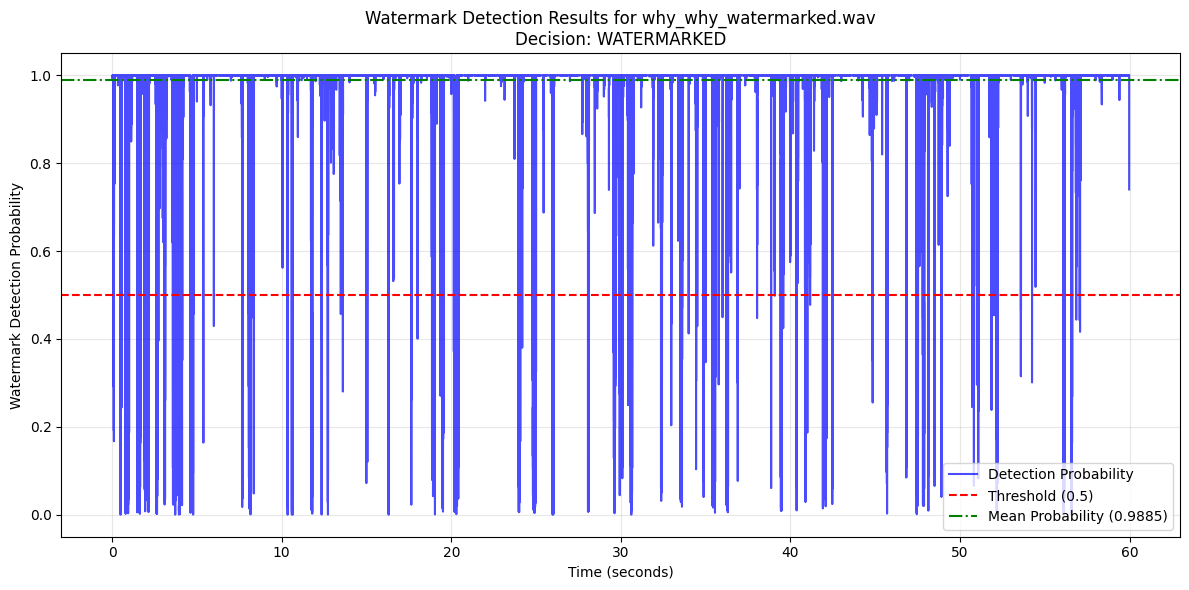

File: inference_results/why_why_watermarked.wav
Detection Probability: 0.9885
Decision: WATERMARKED


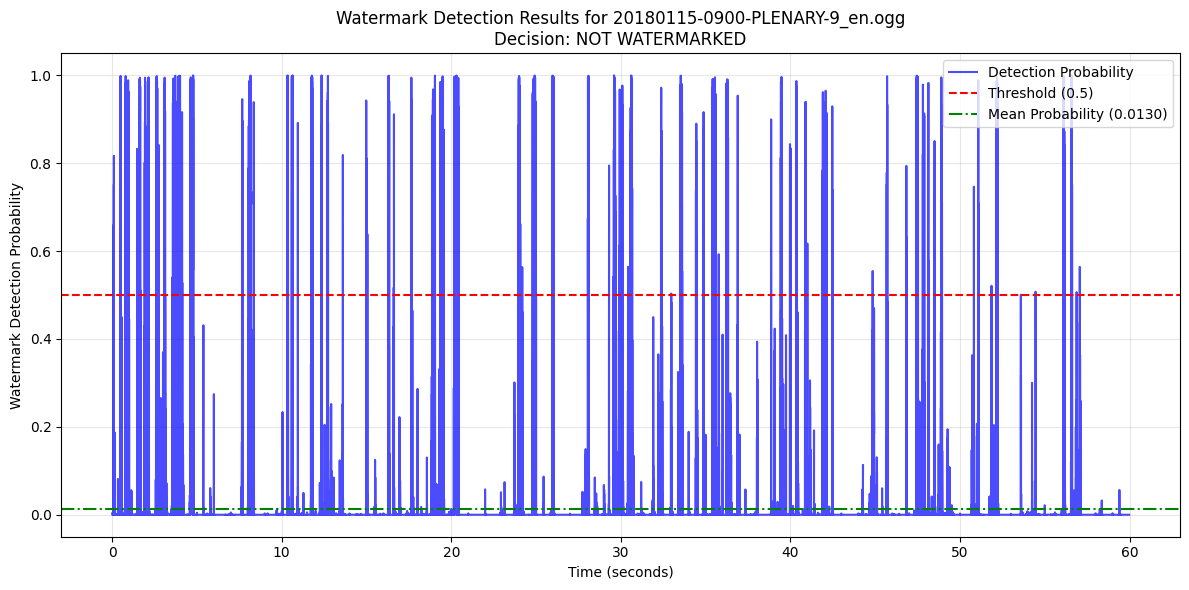


File: data/raw_audios/en/2018/20180115-0900-PLENARY-9_en.ogg
Detection Probability: 0.0130
Decision: NOT WATERMARKED


In [ ]:
def detect_watermark(input_file, detector, detection_threshold=0.5, visualize=True, device="cuda"):
    detector.eval()
    
    waveform, sr = torchaudio.load(input_file)
    if waveform.shape[0] > 1: 
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:  
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)

    total_samples = waveform.shape[1]
    seg_len = SAMPLE_RATE  
    num_full = total_samples // seg_len
    remainder = total_samples % seg_len

    all_probs = []
    all_logits = []
    all_message_logits = []
    
    with torch.no_grad():
        for i in range(num_full):
            start = i * seg_len
            end = start + seg_len
            seg = waveform[:, start:end].to(device)  
            
            seg = seg.unsqueeze(0) 
            
            logits = detector(seg) 
            
            detection_logits = logits[:, :, 0] 
            detection_probs = torch.sigmoid(detection_logits)
            
            if hasattr(detector, 'message_bits') and detector.message_bits > 0:
                message_logits = logits[:, :, 1:].mean(dim=1)  
                all_message_logits.append(message_logits.cpu())
            
            all_logits.append(detection_logits.cpu())
            all_probs.append(detection_probs.cpu())
        
        if remainder > 0:
            seg = waveform[:, num_full * seg_len:]
            padded_seg = F.pad(seg, (0, seg_len - seg.shape[1]))
            padded_seg = padded_seg.to(device)
            padded_seg = padded_seg.unsqueeze(0) 
            
            logits = detector(padded_seg)
            
            detection_logits = logits[:, :remainder, 0]
            detection_probs = torch.sigmoid(detection_logits)
            
            if hasattr(detector, 'message_bits') and detector.message_bits > 0:
                message_logits = logits[:, :remainder, 1:].mean(dim=1)
                all_message_logits.append(message_logits.cpu())
            
            all_logits.append(detection_logits.cpu())
            all_probs.append(detection_probs.cpu())
    
    all_probs_cat = torch.cat([p.flatten() for p in all_probs])
    mean_prob = all_probs_cat.mean().item()
    
    is_watermarked = mean_prob > detection_threshold
    temporal_probs = torch.cat(all_probs, dim=1).flatten().numpy()
    
    result = {
        "mean_probability": mean_prob,
        "is_watermarked": is_watermarked,
        "temporal_probs": temporal_probs,
        "decision": "WATERMARKED" if is_watermarked else "NOT WATERMARKED"
    }
    
    if hasattr(detector, 'message_bits') and detector.message_bits > 0 and all_message_logits:
        message_logits_mean = torch.cat(all_message_logits).mean(dim=0)
        predicted_message = (message_logits_mean > 0).int().tolist()
        result["predicted_message"] = predicted_message
        result["message_confidence"] = torch.sigmoid(message_logits_mean).tolist()
    
    if visualize:
        filename = os.path.basename(input_file)
        
        plt.figure(figsize=(12, 6))
        
        time_axis = np.linspace(0, len(temporal_probs) / SAMPLE_RATE, len(temporal_probs))
        plt.plot(time_axis, temporal_probs, label="Detection Probability", color="blue", alpha=0.7)
        plt.axhline(y=detection_threshold, color="red", linestyle="--", label=f"Threshold ({detection_threshold})")
        plt.axhline(y=mean_prob, color="green", linestyle="-.", label=f"Mean Probability ({mean_prob:.4f})")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Watermark Detection Probability")
        plt.title(f"Watermark Detection Results for {filename}\nDecision: {result['decision']}")
        plt.ylim(-0.05, 1.05)       
        plt.legend() 
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return result


detector = Detector(message_bits=MESSAGE_BITS).to(device)
detector_state = torch.load("detector_best.pth", map_location=device)
load_state_dict_strip_prefix(detector, detector_state, prefix="_orig_mod.")


watermarked_file = "inference_results/why_why_watermarked.wav"
detection_result = detect_watermark(watermarked_file, detector)


print(f"File: {watermarked_file}")
print(f"Detection Probability: {detection_result['mean_probability']:.4f}")
print(f"Decision: {detection_result['decision']}")


original_file = "data/raw_audios/en/2018/20180115-0900-PLENARY-9_en.ogg" 
detection_result = detect_watermark(original_file, detector)
print(f"\nFile: {original_file}")
print(f"Detection Probability: {detection_result['mean_probability']:.4f}")
print(f"Decision: {detection_result['decision']}")


/tmp/ipykernel_16829/3249456264.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_state = torch.load("best_models/generator_best.pth", map_location=device)


Watermark RMS: 0.007788
SI-SNR: 20.71 dB
Power Ratio: 20.71 dB


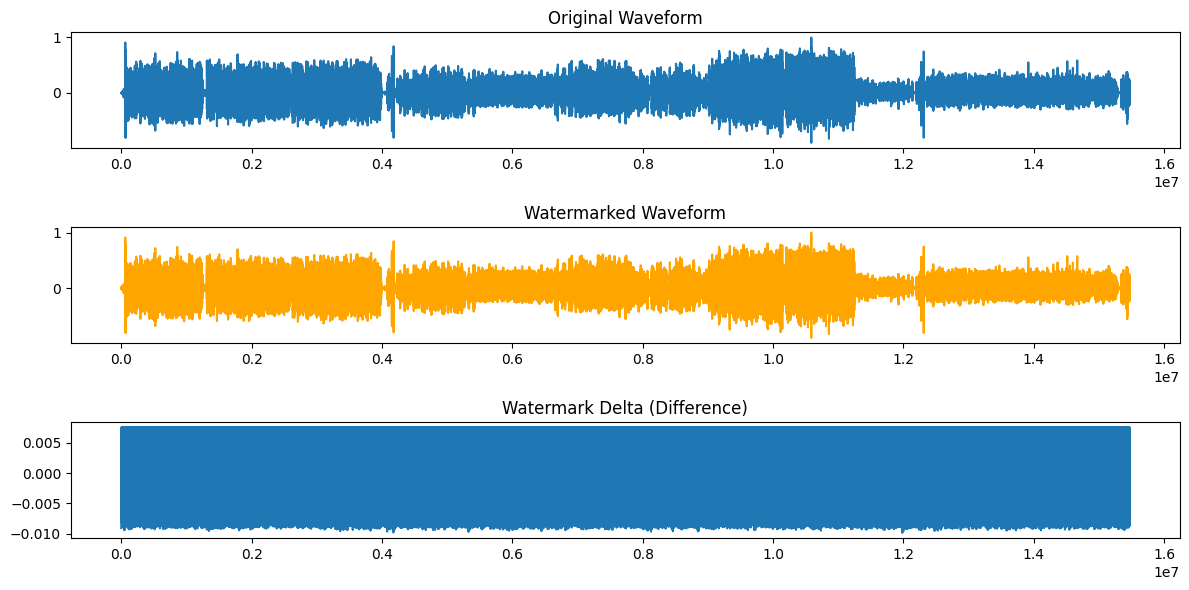

In [ ]:
def generate_watermarked_audio(input_file, generator, output_file=None, message_bits=16, device="cuda"):
    
    generator.eval()
    
    waveform, sr = torchaudio.load(input_file)
    if waveform.shape[0] > 1: 
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)

    total_samples = waveform.shape[1]
    seg_len = SAMPLE_RATE  
    num_full = total_samples // seg_len
    remainder = total_samples % seg_len

    watermarked_segments = []
    delta_segments = []
    
    with torch.no_grad():
        for i in range(num_full):
            start = i * seg_len
            end = start + seg_len
            seg = waveform[:, start:end].to(device) 
            
            message = torch.randint(0, 2 ** message_bits, (1,), device=device)
            
            seg = seg.unsqueeze(0) 

            delta_seg = generator(seg, message) 
            watermarked_seg = seg + delta_seg  
            
            watermarked_segments.append(watermarked_seg.squeeze(0).cpu())
            delta_segments.append(delta_seg.squeeze(0).cpu())

        if remainder > 0:
            seg = waveform[:, num_full * seg_len:]
            padded_seg = F.pad(seg, (0, seg_len - seg.shape[1]))
            padded_seg = padded_seg.to(device)
            
            message = torch.randint(0, 2 ** message_bits, (1,), device=device)
            padded_seg = padded_seg.unsqueeze(0)  
            
            delta_seg = generator(padded_seg, message)
            watermarked_seg = padded_seg + delta_seg
            
            watermarked_seg = watermarked_seg.squeeze(0).cpu()[:, :remainder]
            delta_seg = delta_seg.squeeze(0).cpu()[:, :remainder]
            
            watermarked_segments.append(watermarked_seg)
            delta_segments.append(delta_seg)

    watermarked_waveform = torch.cat(watermarked_segments, dim=1) 
    delta_waveform = torch.cat(delta_segments, dim=1) 
    original_waveform = waveform
    
    watermark_rms = torch.sqrt((delta_waveform ** 2).mean()).item()
    s = original_waveform - original_waveform.mean(dim=1, keepdim=True)
    s_hat = watermarked_waveform - watermarked_waveform.mean(dim=1, keepdim=True)
    
    dot = torch.sum(s * s_hat, dim=1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=1, keepdim=True)
    alpha = dot / (norm_s + 1e-8)
    
    s_target = alpha * s
    e_noise = s_hat - s_target
    
    si_snr = 10 * torch.log10(
        torch.sum(s_target ** 2, dim=1) / (torch.sum(e_noise ** 2, dim=1) + 1e-8)
    ).mean().item()
    
    original_power = torch.mean(original_waveform ** 2).item()
    watermark_power = torch.mean(delta_waveform ** 2).item()
    power_ratio_db = 10 * np.log10(original_power / watermark_power)
    
    if output_file:
        output_dir = os.path.dirname(output_file)
        if output_dir: 
            os.makedirs(output_dir, exist_ok=True)
        torchaudio.save(output_file, watermarked_waveform, SAMPLE_RATE)
    
    return {
        "watermarked_waveform": watermarked_waveform,
        "delta_waveform": delta_waveform,
        "original_waveform": original_waveform,
        "metrics": {
            "watermark_rms": watermark_rms,
            "si_snr_db": si_snr,
            "power_ratio_db": power_ratio_db
        }
    }


if __name__ == "__main__":
    SAMPLE_RATE = 16000  
    MESSAGE_BITS = 16
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    def load_state_dict_strip_prefix(model, state_dict, prefix=""):
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith(prefix):
                new_k = k[len(prefix):]
                new_state_dict[new_k] = v
            else:
                new_state_dict[k] = v
        model.load_state_dict(new_state_dict)
    
    generator = Generator(message_bits=MESSAGE_BITS).to(device)
    generator_state = torch.load("best_models/generator_best.pth", map_location=device)
    load_state_dict_strip_prefix(generator, generator_state, prefix="_orig_mod.")
    

    input_file = "data/raw_audios/en/2016/20160118-0900-PLENARY-19_en.ogg"
    output_file = "watermarked_audio_16_m.wav"
    result = generate_watermarked_audio(input_file, generator, output_file)
  
    print(f"Watermark RMS: {result['metrics']['watermark_rms']:.6f}")
    print(f"SI-SNR: {result['metrics']['si_snr_db']:.2f} dB")
    print(f"Power Ratio: {result['metrics']['power_ratio_db']:.2f} dB")
    
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(result['original_waveform'].numpy().flatten())
    plt.title('Original Waveform')
    plt.subplot(3, 1, 2)
    plt.plot(result['watermarked_waveform'].numpy().flatten(), color='orange')
    plt.title('Watermarked Waveform')
    plt.subplot(3, 1, 3)
    plt.plot(result['delta_waveform'].numpy().flatten())
    plt.title('Watermark Delta (Difference)')
    plt
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3255/1427171463.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detector_state = torch.load("best_models/detector_best.pth", map_location=device)
/tmp/ip

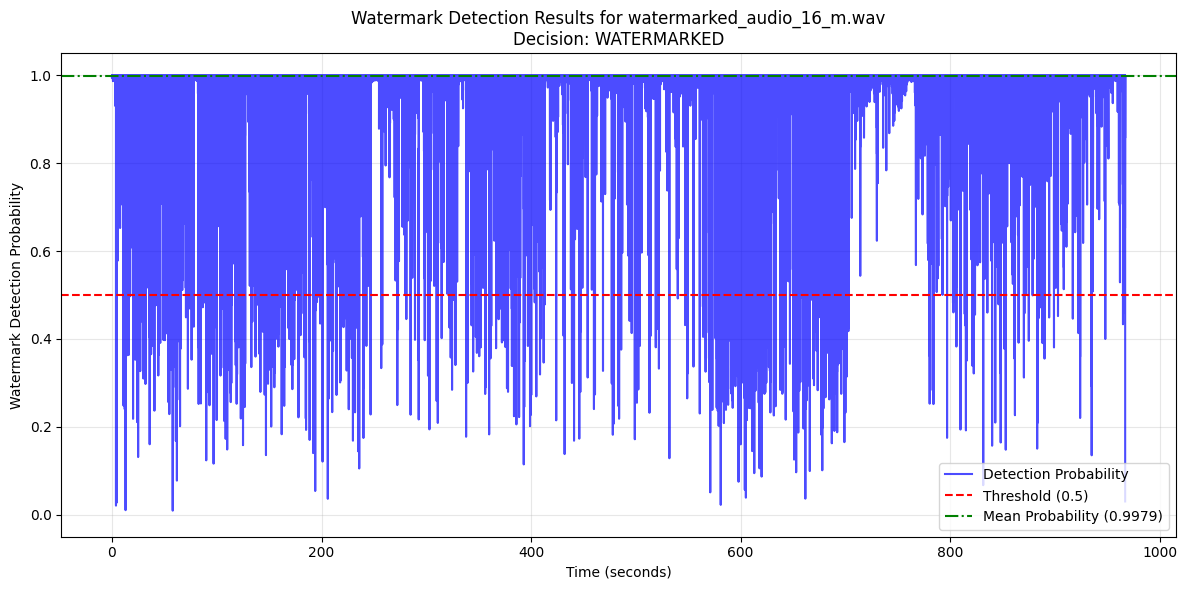

File: watermarked_audio_16_m.wav
Detection Probability: 0.9979
Decision: WATERMARKED


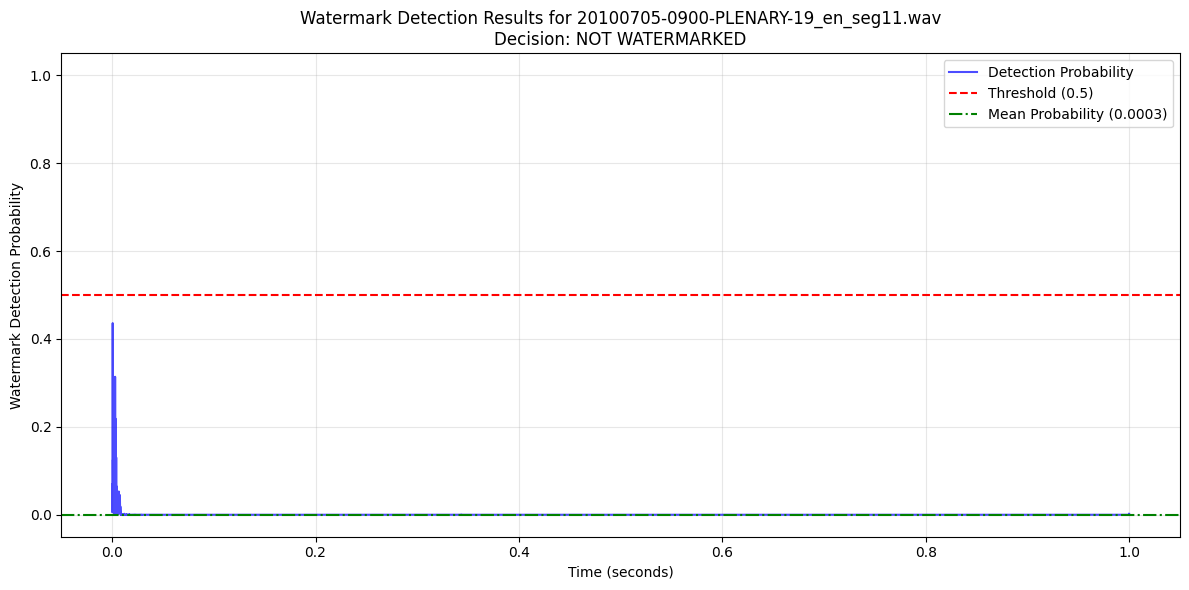


File: /home/spandan/projects/pbl2_audio_watermarking/data/test_5_hours/20100705-0900-PLENARY-19_en_seg11.wav
Detection Probability: 0.0003
Decision: NOT WATERMARKED


In [ ]:
def detect_watermark(input_file, detector, detection_threshold=0.5, visualize=True, device="cuda"):
    detector.eval()
    
    waveform, sr = torchaudio.load(input_file)
    if waveform.shape[0] > 1: 
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:  
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)

    total_samples = waveform.shape[1]
    seg_len = SAMPLE_RATE  
    num_full = total_samples // seg_len
    remainder = total_samples % seg_len

    all_probs = []
    all_logits = []
    all_message_logits = []
    
    with torch.no_grad():
        for i in range(num_full):
            start = i * seg_len
            end = start + seg_len
            seg = waveform[:, start:end].to(device)  
            
            seg = seg.unsqueeze(0) 
            
            logits = detector(seg) 
            
            detection_logits = logits[:, :, 0] 
            detection_probs = torch.sigmoid(detection_logits)
            
            if hasattr(detector, 'message_bits') and detector.message_bits > 0:
                message_logits = logits[:, :, 1:].mean(dim=1)  
                all_message_logits.append(message_logits.cpu())
            
            all_logits.append(detection_logits.cpu())
            all_probs.append(detection_probs.cpu())
        
        if remainder > 0:
            seg = waveform[:, num_full * seg_len:]
            padded_seg = F.pad(seg, (0, seg_len - seg.shape[1]))
            padded_seg = padded_seg.to(device)
            padded_seg = padded_seg.unsqueeze(0) 
            
            logits = detector(padded_seg)
            
            detection_logits = logits[:, :remainder, 0]
            detection_probs = torch.sigmoid(detection_logits)
            
            if hasattr(detector, 'message_bits') and detector.message_bits > 0:
                message_logits = logits[:, :remainder, 1:].mean(dim=1)
                all_message_logits.append(message_logits.cpu())
            
            all_logits.append(detection_logits.cpu())
            all_probs.append(detection_probs.cpu())
    
    all_probs_cat = torch.cat([p.flatten() for p in all_probs])
    mean_prob = all_probs_cat.mean().item()
    
    is_watermarked = mean_prob > detection_threshold
    temporal_probs = torch.cat(all_probs, dim=1).flatten().numpy()
    
    result = {
        "mean_probability": mean_prob,
        "is_watermarked": is_watermarked,
        "temporal_probs": temporal_probs,
        "decision": "WATERMARKED" if is_watermarked else "NOT WATERMARKED"
    }
    
    if hasattr(detector, 'message_bits') and detector.message_bits > 0 and all_message_logits:
        message_logits_mean = torch.cat(all_message_logits).mean(dim=0)
        predicted_message = (message_logits_mean > 0).int().tolist()
        result["predicted_message"] = predicted_message
        result["message_confidence"] = torch.sigmoid(message_logits_mean).tolist()
    
    if visualize:
        filename = os.path.basename(input_file)
        
        plt.figure(figsize=(12, 6))
        
        time_axis = np.linspace(0, len(temporal_probs) / SAMPLE_RATE, len(temporal_probs))
        plt.plot(time_axis, temporal_probs, label="Detection Probability", color="blue", alpha=0.7)
        plt.axhline(y=detection_threshold, color="red", linestyle="--", label=f"Threshold ({detection_threshold})")
        plt.axhline(y=mean_prob, color="green", linestyle="-.", label=f"Mean Probability ({mean_prob:.4f})")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Watermark Detection Probability")
        plt.title(f"Watermark Detection Results for {filename}\nDecision: {result['decision']}")
        plt.ylim(-0.05, 1.05)       
        plt.legend() 
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return result


detector = Detector(message_bits=MESSAGE_BITS).to(device)
detector_state = torch.load("best_models/detector_best.pth", map_location=device)
load_state_dict_strip_prefix(detector, detector_state, prefix="_orig_mod.")


watermarked_file = "watermarked_audio_16_m.wav"
detection_result = detect_watermark(watermarked_file, detector)


print(f"File: {watermarked_file}")
print(f"Detection Probability: {detection_result['mean_probability']:.4f}")
print(f"Decision: {detection_result['decision']}")


original_file = "/home/spandan/projects/pbl2_audio_watermarking/data/test_5_hours/20100705-0900-PLENARY-19_en_seg11.wav" 
detection_result = detect_watermark(original_file, detector)
print(f"\nFile: {original_file}")
print(f"Detection Probability: {detection_result['mean_probability']:.4f}")
print(f"Decision: {detection_result['decision']}")


/tmp/ipykernel_3255/725099245.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device)

Avg Detection Prob (Clean): 0.0029
Avg Detection Prob (Watermarked): 0.9970
Avg SI-SNR: 14.42 dB
Avg Watermark RMS: 0.007787

Classification Report:
              precision    recall  f1-score   support

       Clean       1.00      1.00      1.00     19704
 Watermarked       1.00      1.00      1.00     19704

    accuracy                           1.00     39408
   macro avg       1.00      1.00      1.00     39408
weighted avg       1.00      1.00      1.00     39408



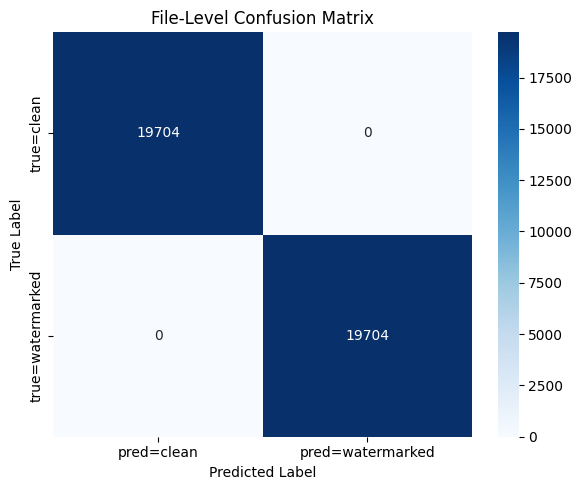

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    has_prefix = any(key.startswith(prefix) for key in state_dict.keys())
    if has_prefix:
        for key, val in state_dict.items():
            if key.startswith(prefix):
                new_state_dict[key[len(prefix):]] = val
            else:
                new_state_dict[key] = val
        model.load_state_dict(new_state_dict, strict=False)
    else:
        model.load_state_dict(state_dict)


def compute_si_snr(s, s_hat, eps=1e-8):
    s = s.squeeze(0)
    s_hat = s_hat.squeeze(0)
    s = s - s.mean(dim=-1, keepdim=True)
    s_hat = s_hat - s_hat.mean(dim=-1, keepdim=True)
    dot = torch.sum(s * s_hat, dim=-1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=-1, keepdim=True)
    alpha = dot / (norm_s + eps)
    s_target = alpha * s
    e_noise = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=-1) / (torch.sum(e_noise ** 2, dim=-1) + eps))
    return si_snr.mean().item()        

def evaluate_unseen_file(filepath, generator, detector, device):
    try:
        waveform, sr = torchaudio.load(filepath)
    except Exception:
        return None, None, None, None

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
    waveform = waveform.to(device)

    clean_probs, wm_probs = [], []
    si_snr_list, rms_list = [], []

    generator.eval(); detector.eval()
    with torch.no_grad():
        for i in range(0, waveform.shape[1], AUDIO_LEN):
            seg = waveform[:, i:i + AUDIO_LEN]
            if seg.shape[1] < AUDIO_LEN:
                seg = F.pad(seg, (0, AUDIO_LEN - seg.shape[1]))
            seg = seg.unsqueeze(0) 
            message = torch.randint(0, 2 ** MESSAGE_BITS, (1,), device=device)
            delta = generator(seg, message)
            seg_w = seg + delta
            logits_clean = detector(seg)[:, :, 0]
            logits_wm    = detector(seg_w)[:, :, 0]
            prob_clean = torch.sigmoid(logits_clean).mean().item()
            prob_wm    = torch.sigmoid(logits_wm).mean().item()
            clean_probs.append(prob_clean)
            wm_probs.append(prob_wm)
            rms_val = torch.sqrt((delta ** 2).mean()).item()
            rms_list.append(rms_val)
            si_val = compute_si_snr(seg, seg_w)
            si_snr_list.append(si_val)

    return (np.mean(clean_probs), np.mean(wm_probs), np.mean(si_snr_list), np.mean(rms_list))

if __name__ == "__main__":
    set_seed(42)

    UNSEEN_DATA_DIR   = "data/test_5_hours"
    GENERATOR_WEIGHTS = "best_models/generator_best.pth"
    DETECTOR_WEIGHTS  = "best_models/detector_best.pth"
    AUDIO_EXTENSIONS  = ['.wav', '.mp3', '.flac', '.ogg']
    generator = Generator(message_bits=MESSAGE_BITS).to(device)
    detector  = Detector(message_bits=MESSAGE_BITS).to(device)
    load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device))
    load_state_dict_strip_prefix(detector,  torch.load(DETECTOR_WEIGHTS,  map_location=device))

    # collect files
    all_files = []
    for ext in AUDIO_EXTENSIONS:
        all_files += glob.glob(os.path.join(UNSEEN_DATA_DIR, '**', f'*{ext}'), recursive=True)

    # evaluate
    all_clean, all_wm, all_si, all_rms = [], [], [], []
    for f in tqdm(all_files, desc="Evaluating Files"):
        c, w, si, rms = evaluate_unseen_file(f, generator, detector, device)
        if c is not None:
            all_clean.append(c); all_wm.append(w)
            all_si.append(si); all_rms.append(rms)

    overall_clean = np.mean(all_clean)
    overall_wm    = np.mean(all_wm)
    overall_si    = np.mean(all_si)
    overall_rms   = np.mean(all_rms)

    print(f"Avg Detection Prob (Clean): {overall_clean:.4f}")
    print(f"Avg Detection Prob (Watermarked): {overall_wm:.4f}")
    print(f"Avg SI-SNR: {overall_si:.2f} dB")
    print(f"Avg Watermark RMS: {overall_rms:.6f}")
    thresh = 0.5
    y_true = [0]*len(all_clean) + [1]*len(all_wm)
    y_pred = [1 if p>=thresh else 0 for p in all_clean] + [1 if p>=thresh else 0 for p in all_wm]

    cm = confusion_matrix(y_true, y_pred)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Clean", "Watermarked"]))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['pred=clean','pred=watermarked'],
                yticklabels=['true=clean','true=watermarked'])
    plt.title('File-Level Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import torch
import torch.nn.functional as F
import torchaudio
import numpy as np
from tqdm import tqdm

# ─── (reuse your existing generate_watermarked_audio here) ─────────────────────
def generate_watermarked_audio(input_file, generator, message_bits, device):
    generator.eval()
    waveform, sr = torchaudio.load(input_file)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)

    seg_len   = SAMPLE_RATE
    total     = waveform.shape[1]
    num_full  = total // seg_len
    remainder = total % seg_len

    wm_segs, delta_segs = [], []
    with torch.no_grad():
        for i in range(num_full):
            chunk = waveform[:, i*seg_len:(i+1)*seg_len].to(device).unsqueeze(0)
            msg   = torch.randint(0, 2**message_bits, (1,), device=device)
            delta = generator(chunk, msg)
            wm_segs.append((chunk + delta).squeeze(0).cpu())
            delta_segs.append(delta.squeeze(0).cpu())

        if remainder:
            tail  = waveform[:, num_full*seg_len:].to(device)
            pad   = F.pad(tail, (0, seg_len - tail.shape[1])).unsqueeze(0)
            msg   = torch.randint(0, 2**message_bits, (1,), device=device)
            delta = generator(pad, msg)
            wm    = (pad + delta).squeeze(0).cpu()[:, :remainder]
            dm    = delta.squeeze(0).cpu()[:, :remainder]
            wm_segs.append(wm)
            delta_segs.append(dm)

    watermarked = torch.cat(wm_segs, dim=1)
    delta_wave  = torch.cat(delta_segs, dim=1)

    # compute metrics
    rms     = torch.sqrt((delta_wave**2).mean()).item()
    orig_p  = torch.mean(waveform**2).item()
    wm_p    = torch.mean(delta_wave**2).item()
    pr_db   = 10 * np.log10(orig_p / wm_p)

    return watermarked, {"watermark_rms": rms, "power_ratio_db": pr_db}

# ─── Updated folder processor ──────────────────────────────────────────────────
def process_folder_with_tqdm(input_folder, generator,
                             message_bits=MESSAGE_BITS, device=device):
    base        = os.path.basename(os.path.abspath(input_folder))
    output_root = os.path.join(os.path.dirname(input_folder), f"watermarked_{base}")
    exts        = (".wav", ".mp3", ".flac", ".ogg", ".m4a", ".aac")

    # 1) build list of all (in, out) paths
    all_files = []
    for root, _, files in os.walk(input_folder):
        rel = os.path.relpath(root, input_folder)
        for fname in files:
            if fname.lower().endswith(exts):
                in_path  = os.path.join(root, fname)
                out_dir  = os.path.join(output_root, rel)
                os.makedirs(out_dir, exist_ok=True)
                out_path = os.path.join(out_dir, f"watermarked_{fname}")
                all_files.append((in_path, out_path))

    # 2) process with one tqdm bar, accumulate metrics
    rms_list = []
    pr_list  = []
    for in_path, out_path in tqdm(all_files,
                                  desc="Watermarking audio files",
                                  unit="file"):
        wm_wave, metrics = generate_watermarked_audio(
            in_path, generator, message_bits, device
        )
        torchaudio.save(out_path, wm_wave, SAMPLE_RATE)
        rms_list.append(metrics["watermark_rms"])
        pr_list.append(metrics["power_ratio_db"])

    # 3) print overall averages once
    count    = len(rms_list)
    avg_rms  = np.mean(rms_list) if count else 0.0
    avg_pr   = np.mean(pr_list)  if count else 0.0
    print(f"\nProcessed {count} files")
    print(f"Average Watermark RMS:        {avg_rms:.6f}")
    print(f"Average Power Ratio (dB):     {avg_pr:.2f}")

# ─── Load your trained generator weights and run ──────────────────────────────
generator.load_state_dict(
    torch.load("generator_best.pth", map_location=device),
    strict=False
)

INPUT_FOLDER = "data/test_5_hours"  
process_folder_with_tqdm(INPUT_FOLDER, generator)


/tmp/ipykernel_12434/1215680779.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("generator_best.pth", map_location=device),
Watermarking audio files: 100%|██


Processed 19704 files
Average Watermark RMS:        0.002930
Average Power Ratio (dB):     23.74


In [ ]:
# import os
# import glob
# import torch
# import torchaudio
# import torch.nn.functional as F
# import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # ─── Assumes you already have Detector defined and DEVICE/SAMPLE_RATE set ─────
# # load your trained detector weights
# detector.load_state_dict(
#     torch.load("detector_best.pth", map_location=device),
#     strict=False
# )
# detector.eval()

# def detect_prob(file_path, detector, sample_rate=SAMPLE_RATE, device=device):
#     """Return average detection probability over 1-s segments of the file."""
#     waveform, sr = torchaudio.load(file_path)
#     if waveform.shape[0] > 1:
#         waveform = waveform.mean(dim=0, keepdim=True)
#     if sr != sample_rate:
#         waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)

#     waveform = waveform.to(device)
#     seg_len  = sample_rate
#     probs    = []

#     with torch.no_grad():
#         for i in range(0, waveform.shape[1], seg_len):
#             seg = waveform[:, i : i+seg_len]
#             if seg.shape[1] < seg_len:
#                 seg = F.pad(seg, (0, seg_len - seg.shape[1]))
#             logits = detector(seg.unsqueeze(0))       # (1, T, output_dim)
#             p      = torch.sigmoid(logits[:, :, 0])   # detection channel
#             probs.append(p.mean().item())

#     return float(np.mean(probs))


# # ─── Collect file paths ────────────────────────────────────────────────────────
# CLEAN_DIR       = "data/test_5_hours"              
# WATERMARKED_DIR = "data/watermarked_test_5_hours"   
# exts = ("*.wav", "*.mp3", "*.flac", "*.ogg", "*.m4a", "*.aac")
# clean_files = []
# for e in exts:
#     clean_files += glob.glob(os.path.join(CLEAN_DIR, "**", e), recursive=True)

# wm_files = []
# for e in exts:
#     wm_files += glob.glob(os.path.join(WATERMARKED_DIR, "**", "watermarked_*" + e[1:]), recursive=True)


# # ─── Run detection & build labels ─────────────────────────────────────────────
# y_true = []
# y_pred = []

# print(f"Evaluating {len(clean_files)} clean files...")
# for f in clean_files:
#     p = detect_prob(f, detector)
#     y_true.append(0)
#     y_pred.append(1 if p >= 0.5 else 0)

# print(f"Evaluating {len(wm_files)} watermarked files...")
# for f in wm_files:
#     p = detect_prob(f, detector)
#     y_true.append(1)
#     y_pred.append(1 if p >= 0.5 else 0)


# # ─── Classification Report ────────────────────────────────────────────────────
# print("\nClassification Report:")
# print(classification_report(y_true, y_pred, target_names=["Clean", "Watermarked"]))


# # ─── Confusion Matrix with Seaborn ─────────────────────────────────────────────
# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(6, 5))
# sns.heatmap(
#     cm, annot=True, fmt="d", cmap="Blues",
#     xticklabels=["pred=Clean", "pred=Watermarked"],
#     yticklabels=["true=Clean", "true=Watermarked"]
# )
# plt.title("Detection Confusion Matrix")
# plt.ylabel("True Label")
# plt.xlabel("Predicted Label")
# plt.tight_layout()
# plt.show()


/tmp/ipykernel_12434/255130899.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("detector_best.pth", map_location=device),


Evaluating 19704 clean files...


Detecting clean: 100%|██████████| 19704/19704 [00:13<00:00, 1419.79file/s]



Evaluating 19704 watermarked files...


Detecting watermarked: 100%|██████████| 19704/19704 [00:12<00:00, 1530.45file/s]



Classification Report:
              precision    recall  f1-score   support

       Clean       1.00      1.00      1.00     19704
 Watermarked       1.00      1.00      1.00     19704

    accuracy                           1.00     39408
   macro avg       1.00      1.00      1.00     39408
weighted avg       1.00      1.00      1.00     39408



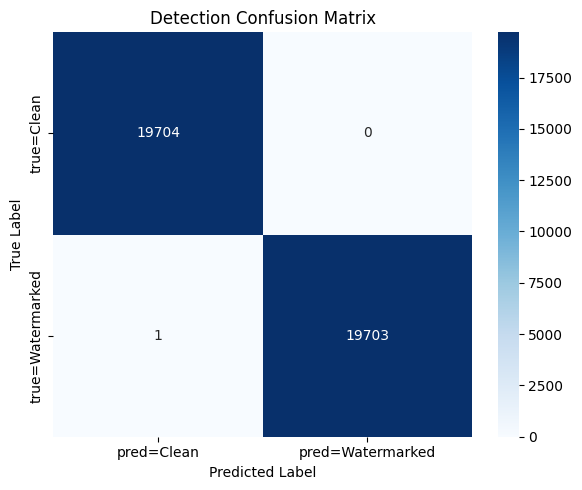

In [ ]:
import os
import glob
import torch
import torchaudio
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ─── Assumes you already have Detector defined and DEVICE/SAMPLE_RATE set ─────
# load your trained detector weights
detector.load_state_dict(
    torch.load("detector_best.pth", map_location=device),
    strict=False
)
detector.eval()

def detect_prob(file_path, detector, sample_rate=SAMPLE_RATE, device=device):
    """Return average detection probability over 1-s segments of the file."""
    waveform, sr = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)

    waveform = waveform.to(device)
    seg_len  = sample_rate
    probs    = []

    with torch.no_grad():
        for i in range(0, waveform.shape[1], seg_len):
            seg = waveform[:, i : i+seg_len]
            if seg.shape[1] < seg_len:
                seg = F.pad(seg, (0, seg_len - seg.shape[1]))
            logits = detector(seg.unsqueeze(0))       # (1, T, output_dim)
            p      = torch.sigmoid(logits[:, :, 0])   # detection channel
            probs.append(p.mean().item())

    return float(np.mean(probs))


# ─── Collect file paths ────────────────────────────────────────────────────────
CLEAN_DIR       = "data/test_5_hours"              
WATERMARKED_DIR = "data/watermarked_test_5_hours"   

exts = ("*.wav", "*.mp3", "*.flac", "*.ogg", "*.m4a", "*.aac")
clean_files = []
for e in exts:
    clean_files += glob.glob(os.path.join(CLEAN_DIR, "**", e), recursive=True)

wm_files = []
for e in exts:
    wm_files += glob.glob(os.path.join(WATERMARKED_DIR, "**", "watermarked_*" + e[1:]), recursive=True)


# ─── Run detection & build labels with progress bars ──────────────────────────
y_true = []
y_pred = []

print(f"Evaluating {len(clean_files)} clean files...")
for f in tqdm(clean_files, desc="Detecting clean", unit="file"):
    p = detect_prob(f, detector)
    y_true.append(0)
    y_pred.append(1 if p >= 0.5 else 0)

print(f"\nEvaluating {len(wm_files)} watermarked files...")
for f in tqdm(wm_files, desc="Detecting watermarked", unit="file"):
    p = detect_prob(f, detector)
    y_true.append(1)
    y_pred.append(1 if p >= 0.5 else 0)


# ─── Classification Report ────────────────────────────────────────────────────
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Clean", "Watermarked"]))


# ─── Confusion Matrix with Seaborn ─────────────────────────────────────────────
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["pred=Clean", "pred=Watermarked"],
    yticklabels=["true=Clean", "true=Watermarked"]
)
plt.title("Detection Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [ ]:
# import os
# import torch
# import torch.nn.functional as F
# import torchaudio
# import numpy as np
# from tqdm import tqdm

# # ─── Watermarking Utilities ───────────────────────────────────────────────────
# def generate_watermarked_audio(input_file, generator, output_file,
#                                message_bits=MESSAGE_BITS, device=device):
#     generator.eval()
#     waveform, sr = torchaudio.load(input_file)
#     if waveform.shape[0] > 1:
#         waveform = waveform.mean(dim=0, keepdim=True)
#     if sr != SAMPLE_RATE:
#         waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
    
#     seg_len = SAMPLE_RATE
#     total = waveform.shape[1]
#     num_full = total // seg_len
#     remainder = total % seg_len
#     wm_segs, delta_segs = [], []
    
#     with torch.no_grad():
#         for i in range(num_full):
#             seg = waveform[:, i*seg_len:(i+1)*seg_len].to(device).unsqueeze(0)
#             msg = torch.randint(0, 2**message_bits, (1,), device=device)
#             delta = generator(seg, msg)
#             wm_segs.append((seg + delta).squeeze(0).cpu())
#             delta_segs.append(delta.squeeze(0).cpu())
        
#         if remainder > 0:
#             seg = waveform[:, num_full*seg_len:]
#             padded = F.pad(seg, (0, seg_len - seg.shape[1])).to(device).unsqueeze(0)
#             msg = torch.randint(0, 2**message_bits, (1,), device=device)
#             delta = generator(padded, msg)
#             wm = (padded + delta).squeeze(0).cpu()[:, :remainder]
#             dm = delta.squeeze(0).cpu()[:, :remainder]
#             wm_segs.append(wm)
#             delta_segs.append(dm)
    
#     watermarked = torch.cat(wm_segs, dim=1)
#     delta_wave = torch.cat(delta_segs, dim=1)
    
#     os.makedirs(os.path.dirname(output_file), exist_ok=True)
#     torchaudio.save(output_file, watermarked, SAMPLE_RATE)
    
#     rms = torch.sqrt((delta_wave**2).mean()).item()
#     orig_p = torch.mean(waveform**2).item()
#     wm_p = torch.mean(delta_wave**2).item()
#     pr_db = 10 * np.log10(orig_p / wm_p)
    
#     return {"watermark_rms": rms, "power_ratio_db": pr_db}

# def process_folder_with_progress(input_folder, generator,
#                                  message_bits=MESSAGE_BITS, device=device):
#     base = os.path.basename(os.path.abspath(input_folder))
#     output_root = os.path.join(os.path.dirname(input_folder), f"watermarked_{base}")
#     exts = (".wav", ".mp3", ".flac", ".ogg", ".m4a", ".aac")
    
#     # 1) Gather all files
#     all_files = []
#     for root, _, files in os.walk(input_folder):
#         rel = os.path.relpath(root, input_folder)
#         for fname in files:
#             if fname.lower().endswith(exts):
#                 in_path = os.path.join(root, fname)
#                 out_dir = os.path.join(output_root, rel)
#                 out_path = os.path.join(out_dir, f"watermarked_{fname}")
#                 all_files.append((in_path, out_path))
    
#     # 2) Process with tqdm
#     total_rms = 0.0
#     total_pr_db = 0.0
#     successful_files = 0
#     error_count = 0
    
#     for in_path, out_path in tqdm(all_files, desc="Watermarking audio files", unit="file"):
#         try:
#             m = generate_watermarked_audio(in_path, generator, out_path,
#                                          message_bits, device)
#             total_rms += m['watermark_rms']
#             total_pr_db += m['power_ratio_db']
#             successful_files += 1
#         except Exception as e:
#             error_count += 1
#             tqdm.write(f"Error processing {os.path.basename(in_path)}: {str(e)}")
    
#     # Print summary statistics at the end
#     if successful_files > 0:
#         avg_rms = total_rms / successful_files
#         avg_pr_db = total_pr_db / successful_files
#         print(f"\nProcessing complete: {successful_files} files successfully watermarked")
#         print(f"Average RMS: {avg_rms:.6f}, Average PR: {avg_pr_db:.2f} dB")
#         if error_count > 0:
#             print(f"Errors encountered: {error_count} files")
#     else:
#         print("No files were successfully processed.")

# # ─── Load Your Best Generator Weights ─────────────────────────────────────────
# generator.load_state_dict(
#     torch.load("generator_best.pth", map_location=device),
#     strict=False  # or strip prefixes if needed
# )

# # ─── Run Recursive Watermarking with Progress Bar ────────────────────────────
# INPUT_FOLDER = "data/test_5_hours"  # ← adjust as needed
# process_folder_with_progress(INPUT_FOLDER, generator)

/tmp/ipykernel_12434/281138243.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("generator_best.pth", map_location=device),
Watermarking audio files:   2%|▏ 

KeyboardInterrupt: 

/tmp/ipykernel_13163/3271481854.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=devic

Avg Detection Prob (Clean): 0.0877
Avg Detection Prob (Watermarked): 0.9553
Avg SI-SNR: -inf dB
Avg Watermark RMS: 0.007916

Classification Report:
              precision    recall  f1-score   support

       Clean       1.00      1.00      1.00       999
 Watermarked       1.00      1.00      1.00       999

    accuracy                           1.00      1998
   macro avg       1.00      1.00      1.00      1998
weighted avg       1.00      1.00      1.00      1998



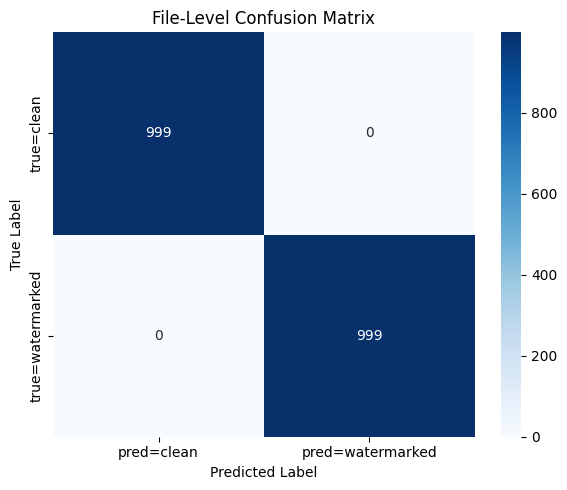

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    has_prefix = any(key.startswith(prefix) for key in state_dict.keys())
    if has_prefix:
        for key, val in state_dict.items():
            if key.startswith(prefix):
                new_state_dict[key[len(prefix):]] = val
            else:
                new_state_dict[key] = val
        model.load_state_dict(new_state_dict, strict=False)
    else:
        model.load_state_dict(state_dict)


def compute_si_snr(s, s_hat, eps=1e-8):
    s = s.squeeze(0)
    s_hat = s_hat.squeeze(0)
    s = s - s.mean(dim=-1, keepdim=True)
    s_hat = s_hat - s_hat.mean(dim=-1, keepdim=True)
    dot = torch.sum(s * s_hat, dim=-1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=-1, keepdim=True)
    alpha = dot / (norm_s + eps)
    s_target = alpha * s
    e_noise = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=-1) / (torch.sum(e_noise ** 2, dim=-1) + eps))
    return si_snr.mean().item()        

def evaluate_unseen_file(filepath, generator, detector, device):
    try:
        waveform, sr = torchaudio.load(filepath)
    except Exception:
        return None, None, None, None

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
    waveform = waveform.to(device)

    clean_probs, wm_probs = [], []
    si_snr_list, rms_list = [], []

    generator.eval(); detector.eval()
    with torch.no_grad():
        for i in range(0, waveform.shape[1], AUDIO_LEN):
            seg = waveform[:, i:i + AUDIO_LEN]
            if seg.shape[1] < AUDIO_LEN:
                seg = F.pad(seg, (0, AUDIO_LEN - seg.shape[1]))
            seg = seg.unsqueeze(0) 
            message = torch.randint(0, 2 ** MESSAGE_BITS, (1,), device=device)
            delta = generator(seg, message)
            seg_w = seg + delta
            logits_clean = detector(seg)[:, :, 0]
            logits_wm    = detector(seg_w)[:, :, 0]
            prob_clean = torch.sigmoid(logits_clean).mean().item()
            prob_wm    = torch.sigmoid(logits_wm).mean().item()
            clean_probs.append(prob_clean)
            wm_probs.append(prob_wm)
            rms_val = torch.sqrt((delta ** 2).mean()).item()
            rms_list.append(rms_val)
            si_val = compute_si_snr(seg, seg_w)
            si_snr_list.append(si_val)

    return (np.mean(clean_probs), np.mean(wm_probs), np.mean(si_snr_list), np.mean(rms_list))

if __name__ == "__main__":
    set_seed(42)

    UNSEEN_DATA_DIR   = "data/genres_original"
    GENERATOR_WEIGHTS = "generator_best.pth"
    DETECTOR_WEIGHTS  = "detector_best.pth"
    AUDIO_EXTENSIONS  = ['.wav', '.mp3', '.flac', '.ogg']
    generator = Generator(message_bits=MESSAGE_BITS).to(device)
    detector  = Detector(message_bits=MESSAGE_BITS).to(device)
    load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device))
    load_state_dict_strip_prefix(detector,  torch.load(DETECTOR_WEIGHTS,  map_location=device))

    # collect files
    all_files = []
    for ext in AUDIO_EXTENSIONS:
        all_files += glob.glob(os.path.join(UNSEEN_DATA_DIR, '**', f'*{ext}'), recursive=True)

    # evaluate
    all_clean, all_wm, all_si, all_rms = [], [], [], []
    for f in tqdm(all_files, desc="Evaluating Files"):
        c, w, si, rms = evaluate_unseen_file(f, generator, detector, device)
        if c is not None:
            all_clean.append(c); all_wm.append(w)
            all_si.append(si); all_rms.append(rms)

    overall_clean = np.mean(all_clean)
    overall_wm    = np.mean(all_wm)
    overall_si    = np.mean(all_si)
    overall_rms   = np.mean(all_rms)

    print(f"Avg Detection Prob (Clean): {overall_clean:.4f}")
    print(f"Avg Detection Prob (Watermarked): {overall_wm:.4f}")
    print(f"Avg SI-SNR: {overall_si:.2f} dB")
    print(f"Avg Watermark RMS: {overall_rms:.6f}")
    thresh = 0.5
    y_true = [0]*len(all_clean) + [1]*len(all_wm)
    y_pred = [1 if p>=thresh else 0 for p in all_clean] + [1 if p>=thresh else 0 for p in all_wm]

    cm = confusion_matrix(y_true, y_pred)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Clean", "Watermarked"]))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['pred=clean','pred=watermarked'],
                yticklabels=['true=clean','true=watermarked'])
    plt.title('File-Level Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    has_prefix = any(key.startswith(prefix) for key in state_dict.keys())
    if has_prefix:
        for key, val in state_dict.items():
            if key.startswith(prefix):
                new_state_dict[key[len(prefix):]] = val
            else:
                new_state_dict[key] = val
        model.load_state_dict(new_state_dict, strict=False)
    else:
        model.load_state_dict(state_dict)


def compute_si_snr(s, s_hat, eps=1e-8):
    s = s.squeeze(0)
    s_hat = s_hat.squeeze(0)
    s = s - s.mean(dim=-1, keepdim=True)
    s_hat = s_hat - s_hat.mean(dim=-1, keepdim=True)
    dot = torch.sum(s * s_hat, dim=-1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=-1, keepdim=True)
    alpha = dot / (norm_s + eps)
    s_target = alpha * s
    e_noise = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=-1) / (torch.sum(e_noise ** 2, dim=-1) + eps))
    return si_snr.mean().item()        

def evaluate_unseen_file(filepath, generator, detector, device):
    try:
        waveform, sr = torchaudio.load(filepath)
    except Exception:
        return None, None, None, None

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
    waveform = waveform.to(device)

    clean_probs, wm_probs = [], []
    si_snr_list, rms_list = [], []

    generator.eval(); detector.eval()
    with torch.no_grad():
        for i in range(0, waveform.shape[1], AUDIO_LEN):
            seg = waveform[:, i:i + AUDIO_LEN]
            if seg.shape[1] < AUDIO_LEN:
                seg = F.pad(seg, (0, AUDIO_LEN - seg.shape[1]))
            seg = seg.unsqueeze(0) 
            message = torch.randint(0, 2 ** MESSAGE_BITS, (1,), device=device)
            delta = generator(seg, message)
            seg_w = seg + delta
            logits_clean = detector(seg)[:, :, 0]
            logits_wm    = detector(seg_w)[:, :, 0]
            prob_clean = torch.sigmoid(logits_clean).mean().item()
            prob_wm    = torch.sigmoid(logits_wm).mean().item()
            clean_probs.append(prob_clean)
            wm_probs.append(prob_wm)
            rms_val = torch.sqrt((delta ** 2).mean()).item()
            rms_list.append(rms_val)
            si_val = compute_si_snr(seg, seg_w)
            si_snr_list.append(si_val)

    return (np.mean(clean_probs), np.mean(wm_probs), np.mean(si_snr_list), np.mean(rms_list))

if __name__ == "__main__":
    set_seed(42)

    UNSEEN_DATA_DIR   = "data/fma_small (1)/fma_small"
    GENERATOR_WEIGHTS = "generator_best.pth"
    DETECTOR_WEIGHTS  = "detector_best.pth"
    AUDIO_EXTENSIONS  = ['.wav', '.mp3', '.flac', '.ogg']
    generator = Generator(message_bits=MESSAGE_BITS).to(device)
    detector  = Detector(message_bits=MESSAGE_BITS).to(device)
    load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device))
    load_state_dict_strip_prefix(detector,  torch.load(DETECTOR_WEIGHTS,  map_location=device))

    # collect files
    all_files = []
    for ext in AUDIO_EXTENSIONS:
        all_files += glob.glob(os.path.join(UNSEEN_DATA_DIR, '**', f'*{ext}'), recursive=True)

    # evaluate
    all_clean, all_wm, all_si, all_rms = [], [], [], []
    for f in tqdm(all_files, desc="Evaluating Files"):
        c, w, si, rms = evaluate_unseen_file(f, generator, detector, device)
        if c is not None:
            all_clean.append(c); all_wm.append(w)
            all_si.append(si); all_rms.append(rms)

    overall_clean = np.mean(all_clean)
    overall_wm    = np.mean(all_wm)
    overall_si    = np.mean(all_si)
    overall_rms   = np.mean(all_rms)

    print(f"Avg Detection Prob (Clean): {overall_clean:.4f}")
    print(f"Avg Detection Prob (Watermarked): {overall_wm:.4f}")
    print(f"Avg SI-SNR: {overall_si:.2f} dB")
    print(f"Avg Watermark RMS: {overall_rms:.6f}")
    thresh = 0.5
    y_true = [0]*len(all_clean) + [1]*len(all_wm)
    y_pred = [1 if p>=thresh else 0 for p in all_clean] + [1 if p>=thresh else 0 for p in all_wm]

    cm = confusion_matrix(y_true, y_pred)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Clean", "Watermarked"]))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['pred=clean','pred=watermarked'],
                yticklabels=['true=clean','true=watermarked'])
    plt.title('File-Level Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_15274/3846911725.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=devic

KeyboardInterrupt: 

In [ ]:
# from pesq import pesq
# from pystoi import stoi

# # ---------------------- Constants ---------------------- #
# SAMPLE_RATE = 16000
# AUDIO_LEN = 16000
# MESSAGE_BITS = 16  # or set this to your actual value
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ---------------------- Utility Functions ---------------------- #
# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

# def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
#     new_state_dict = {}
#     has_prefix = any(key.startswith(prefix) for key in state_dict.keys())
#     if has_prefix:
#         for key, val in state_dict.items():
#             if key.startswith(prefix):
#                 new_state_dict[key[len(prefix):]] = val
#             else:
#                 new_state_dict[key] = val
#         model.load_state_dict(new_state_dict, strict=False)
#     else:
#         model.load_state_dict(state_dict)

# def compute_si_snr(s, s_hat, eps=1e-8):
#     s = s.squeeze(0)
#     s_hat = s_hat.squeeze(0)
#     s = s - s.mean(dim=-1, keepdim=True)
#     s_hat = s_hat - s_hat.mean(dim=-1, keepdim=True)
#     dot = torch.sum(s * s_hat, dim=-1, keepdim=True)
#     norm_s = torch.sum(s ** 2, dim=-1, keepdim=True)
#     alpha = dot / (norm_s + eps)
#     s_target = alpha * s
#     e_noise = s_hat - s_target
#     si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=-1) / (torch.sum(e_noise ** 2, dim=-1) + eps))
#     return si_snr.mean().item()

# def evaluate_unseen_file(filepath, generator, detector, device):
#     try:
#         waveform, sr = torchaudio.load(filepath)
#     except Exception:
#         return None, None, None, None, None, None

#     if waveform.shape[0] > 1:
#         waveform = waveform.mean(dim=0, keepdim=True)
#     if sr != SAMPLE_RATE:
#         waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
#     waveform = waveform.to(device)

#     clean_probs, wm_probs = [], []
#     si_snr_list, rms_list = [], []
#     pesq_list, stoi_list = [], []

#     generator.eval()
#     detector.eval()
#     with torch.no_grad():
#         for i in range(0, waveform.shape[1], AUDIO_LEN):
#             seg = waveform[:, i:i + AUDIO_LEN]
#             if seg.shape[1] < AUDIO_LEN:
#                 seg = F.pad(seg, (0, AUDIO_LEN - seg.shape[1]))
#             seg = seg.unsqueeze(0)
#             message = torch.randint(0, 2 ** MESSAGE_BITS, (1,), device=device)
#             delta = generator(seg, message)
#             seg_w = seg + delta

#             logits_clean = detector(seg)[:, :, 0]
#             logits_wm = detector(seg_w)[:, :, 0]
#             prob_clean = torch.sigmoid(logits_clean).mean().item()
#             prob_wm = torch.sigmoid(logits_wm).mean().item()
#             clean_probs.append(prob_clean)
#             wm_probs.append(prob_wm)

#             rms_val = torch.sqrt((delta ** 2).mean()).item()
#             rms_list.append(rms_val)

#             si_val = compute_si_snr(seg, seg_w)
#             si_snr_list.append(si_val)

#             clean_np = seg.squeeze().cpu().numpy()
#             wm_np = seg_w.squeeze().cpu().numpy()

#             try:
#                 pesq_val = pesq(SAMPLE_RATE, clean_np, wm_np, 'wb')
#                 pesq_list.append(pesq_val)
#             except:
#                 pass

#             try:
#                 stoi_val = stoi(clean_np, wm_np, SAMPLE_RATE, extended=False)
#                 stoi_list.append(stoi_val)
#             except:
#                 pass

#     return (
#         np.mean(clean_probs),
#         np.mean(wm_probs),
#         np.mean(si_snr_list),
#         np.mean(rms_list),
#         np.mean(pesq_list) if pesq_list else None,
#         np.mean(stoi_list) if stoi_list else None,
#     )

# # ---------------------- Main Evaluation ---------------------- #
# if __name__ == "__main__":
#     set_seed(42)

#     UNSEEN_DATA_DIR = "data/test_5_hours"
#     GENERATOR_WEIGHTS = "generator_best.pth"
#     DETECTOR_WEIGHTS = "detector_best.pth"
#     AUDIO_EXTENSIONS = ['.wav', '.mp3', '.flac', '.ogg']

#     generator = Generator(message_bits=MESSAGE_BITS).to(device)
#     detector = Detector(message_bits=MESSAGE_BITS).to(device)
#     load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device))
#     load_state_dict_strip_prefix(detector, torch.load(DETECTOR_WEIGHTS, map_location=device))

#     all_files = []
#     for ext in AUDIO_EXTENSIONS:
#         all_files += glob.glob(os.path.join(UNSEEN_DATA_DIR, '**', f'*{ext}'), recursive=True)

#     all_clean, all_wm, all_si, all_rms = [], [], [], []
#     all_pesq, all_stoi = [], []

#     for f in tqdm(all_files, desc="Evaluating Files"):
#         c, w, si, rms, pesq_val, stoi_val = evaluate_unseen_file(f, generator, detector, device)
#         if c is not None:
#             all_clean.append(c); all_wm.append(w)
#             all_si.append(si); all_rms.append(rms)
#             if pesq_val: all_pesq.append(pesq_val)
#             if stoi_val: all_stoi.append(stoi_val)

#     print(f"Avg Detection Prob (Clean): {np.mean(all_clean):.4f}")
#     print(f"Avg Detection Prob (Watermarked): {np.mean(all_wm):.4f}")
#     print(f"Avg SI-SNR: {np.mean(all_si):.2f} dB")
#     print(f"Avg Watermark RMS: {np.mean(all_rms):.6f}")
#     print(f"Avg PESQ: {np.mean(all_pesq):.3f}" if all_pesq else "PESQ not computed")
#     print(f"Avg STOI: {np.mean(all_stoi):.3f}" if all_stoi else "STOI not computed")

#     thresh = 0.5
#     y_true = [0] * len(all_clean) + [1] * len(all_wm)
#     y_pred = [1 if p >= thresh else 0 for p in all_clean] + [1 if p >= thresh else 0 for p in all_wm]

#     cm = confusion_matrix(y_true, y_pred)
#     print("\nClassification Report:")
#     print(classification_report(y_true, y_pred, target_names=["Clean", "Watermarked"]))

#     plt.figure(figsize=(6, 5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=['pred=clean', 'pred=watermarked'],
#                 yticklabels=['true=clean', 'true=watermarked'])
#     plt.title('File-Level Confusion Matrix')
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.tight_layout()
#     plt.show()


/tmp/ipykernel_6235/730529755.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device

/tmp/ipykernel_27091/1050399442.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state_dict_strip_prefix(generator, torch.load(GEN_WEIGHTS, map_location=device))
/t

Loading models…
Found 2703 files. Beginning evaluation…


Evaluating Files: 100%|██████████| 2703/2703 [03:29<00:00, 12.91it/s]



Avg SI‑SNR (dB):          -inf
Avg Watermark RMS:        0.007788

Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00      2703
 watermarked       1.00      1.00      1.00      2703

    accuracy                           1.00      5406
   macro avg       1.00      1.00      1.00      5406
weighted avg       1.00      1.00      1.00      5406


--- Confusion Matrix ---


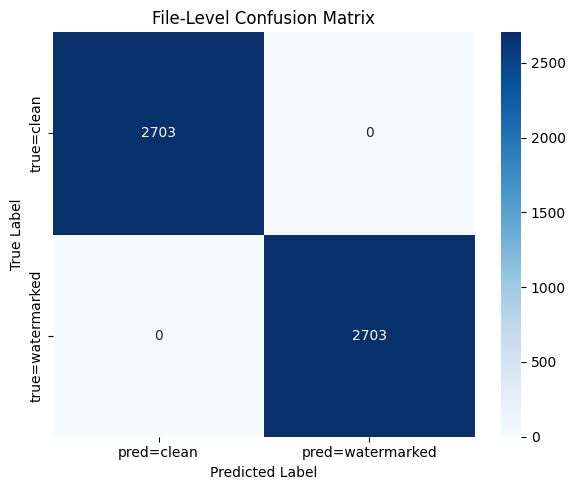


--- Detection Probabilities ---
Clean:      0.0228 ± 0.0222
Watermarked:0.9839 ± 0.0149

Excellent generalization: detector clearly distinguishes clean vs. watermarked.


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    has_prefix = any(key.startswith(prefix) for key in state_dict.keys())
    if has_prefix:
        for key, val in state_dict.items():
            if key.startswith(prefix):
                new_state_dict[key[len(prefix):]] = val
            else:
                new_state_dict[key] = val
        model.load_state_dict(new_state_dict, strict=False)
    else:
        model.load_state_dict(state_dict)


def compute_si_snr(s, s_hat, eps=1e-8):
    s = s.squeeze(0)
    s_hat = s_hat.squeeze(0)
    s = s - s.mean(dim=-1, keepdim=True)
    s_hat = s_hat - s_hat.mean(dim=-1, keepdim=True)
    dot = torch.sum(s * s_hat, dim=-1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=-1, keepdim=True)
    alpha = dot / (norm_s + eps)
    s_target = alpha * s
    e_noise = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=-1) / (torch.sum(e_noise ** 2, dim=-1) + eps))
    return si_snr.mean().item()        

def evaluate_unseen_file(filepath, generator, detector, device):
    try:
        waveform, sr = torchaudio.load(filepath)
    except Exception:
        return None, None, None, None

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
    waveform = waveform.to(device)

    clean_probs, wm_probs = [], []
    si_snr_list, rms_list = [], []

    generator.eval(); detector.eval()
    with torch.no_grad():
        for i in range(0, waveform.shape[1], AUDIO_LEN):
            seg = waveform[:, i:i + AUDIO_LEN]
            if seg.shape[1] < AUDIO_LEN:
                seg = F.pad(seg, (0, AUDIO_LEN - seg.shape[1]))
            seg = seg.unsqueeze(0) 
            message = torch.randint(0, 2 ** MESSAGE_BITS, (1,), device=device)
            delta = generator(seg, message)
            seg_w = seg + delta
            logits_clean = detector(seg)[:, :, 0]
            logits_wm    = detector(seg_w)[:, :, 0]
            prob_clean = torch.sigmoid(logits_clean).mean().item()
            prob_wm    = torch.sigmoid(logits_wm).mean().item()
            clean_probs.append(prob_clean)
            wm_probs.append(prob_wm)
            rms_val = torch.sqrt((delta ** 2).mean()).item()
            rms_list.append(rms_val)
            si_val = compute_si_snr(seg, seg_w)
            si_snr_list.append(si_val)

    return (np.mean(clean_probs), np.mean(wm_probs), np.mean(si_snr_list), np.mean(rms_list))


set_seed(42)

UNSEEN_DATA_DIR   = "data/dev-clean/LibriSpeech/dev-clean"
GEN_WEIGHTS       = "generator_best.pth"
DET_WEIGHTS       = "detector_best.pth"
AUDIO_EXTENSIONS  = ['.wav', '.mp3', '.flac', '.ogg']

# sanity checks
if not os.path.isdir(UNSEEN_DATA_DIR):
    raise FileNotFoundError(f"Directory not found: {UNSEEN_DATA_DIR}")
if not os.path.exists(GEN_WEIGHTS):
    raise FileNotFoundError(f"Generator weights not found: {GEN_WEIGHTS}")
if not os.path.exists(DET_WEIGHTS):
    raise FileNotFoundError(f"Detector weights not found: {DET_WEIGHTS}")

print("Loading models…")
generator = Generator(message_bits=MESSAGE_BITS).to(device)
detector  = Detector(message_bits=MESSAGE_BITS).to(device)
load_state_dict_strip_prefix(generator, torch.load(GEN_WEIGHTS, map_location=device))
load_state_dict_strip_prefix(detector,  torch.load(DET_WEIGHTS, map_location=device))
generator.eval()
detector.eval()

# gather files
all_files = []
for ext in AUDIO_EXTENSIONS:
    all_files.extend(glob.glob(os.path.join(UNSEEN_DATA_DIR, "**", f"*{ext}"), recursive=True))
if not all_files:
    raise RuntimeError(f"No audio files found in {UNSEEN_DATA_DIR}")

print(f"Found {len(all_files)} files. Beginning evaluation…")

# storage lists
all_clean_probs      = []
all_watermarked_probs= []
all_si_snr           = []
all_rms              = []

for filepath in tqdm(all_files, desc="Evaluating Files"):
    clean_p, wm_p, si_p, rms_p = evaluate_unseen_file(filepath, generator, detector, device)
    if clean_p is not None:
        all_clean_probs.append(clean_p)
        all_watermarked_probs.append(wm_p)
        all_si_snr.append(si_p)
        all_rms.append(rms_p)

# compute averages
overall_avg_clean      = np.mean(all_clean_probs)
overall_avg_watermarked= np.mean(all_watermarked_probs)
overall_avg_si_snr     = np.mean(all_si_snr)
overall_avg_rms        = np.mean(all_rms)
std_clean              = np.std(all_clean_probs)
std_watermarked        = np.std(all_watermarked_probs)

# print SI‑SNR and RMS
print(f"\nAvg SI‑SNR (dB):          {overall_avg_si_snr:.2f}")
print(f"Avg Watermark RMS:        {overall_avg_rms:.6f}")

# prepare for confusion & report
threshold = 0.5
y_true  = [0]*len(all_clean_probs) + [1]*len(all_watermarked_probs)
y_pred  = [1 if p>threshold else 0 for p in all_clean_probs] \
        + [1 if p>threshold else 0 for p in all_watermarked_probs]

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["clean", "watermarked"]))

print("\n--- Confusion Matrix ---")
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pred=clean", "pred=watermarked"],
            yticklabels=["true=clean", "true=watermarked"])
plt.title("File‑Level Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

print("\n--- Detection Probabilities ---")
print(f"Clean:      {overall_avg_clean:.4f} ± {std_clean:.4f}")
print(f"Watermarked:{overall_avg_watermarked:.4f} ± {std_watermarked:.4f}\n")

# interpretation
if overall_avg_clean < 0.1 and overall_avg_watermarked > 0.9:
    print("Excellent generalization: detector clearly distinguishes clean vs. watermarked.")
elif overall_avg_clean > 0.2:
    print(f"High false positives on clean audio ({overall_avg_clean:.2f}).")
elif overall_avg_watermarked < 0.8:
    print(f"Low detection on watermarked audio ({overall_avg_watermarked:.2f}).")
else:
    print("Moderate performance; consider further tuning or more data.")


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

# Convert lists to numpy arrays
y_true_arr = np.array(y_true)
y_pred_arr = np.array(y_pred)

# Set up k-fold cross-validation (e.g., 5 folds)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_accuracies = []

print("\n--- K-Fold Cross Validation Accuracy ---")
for fold, (train_idx, test_idx) in enumerate(kf.split(y_true_arr), 1):
    y_true_fold = y_true_arr[test_idx]
    y_pred_fold = y_pred_arr[test_idx]
    fold_acc = accuracy_score(y_true_fold, y_pred_fold)
    fold_accuracies.append(fold_acc)
    print(f"Fold {fold}: Accuracy = {fold_acc:.4f}")

mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f"\nMean CV Accuracy: {mean_accuracy:.4f} (+/- {std_accuracy:.4f})")



--- K-Fold Cross Validation Accuracy ---
Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000

Mean CV Accuracy: 1.0000 (+/- 0.0000)


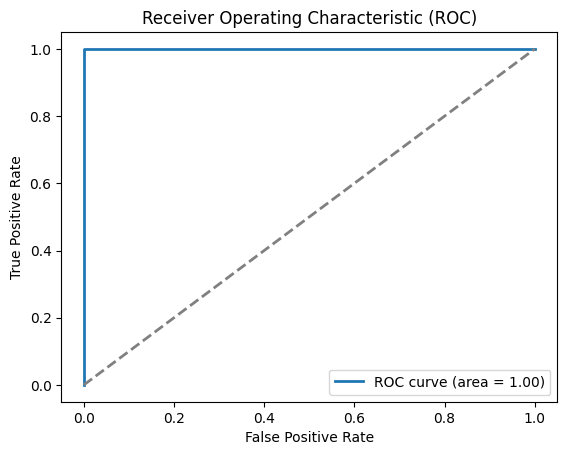

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_true = [0] * len(all_clean_probs) + [1] * len(all_watermarked_probs)
y_scores = all_clean_probs + all_watermarked_probs

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


/tmp/ipykernel_27091/4009097707.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=devi

Loading models...
Stripping prefix '_orig_mod.' from state_dict keys.
Stripping prefix '_orig_mod.' from state_dict keys.
Found 13 files. Beginning evaluation...


Evaluating Unseen Files:  15%|█▌        | 2/13 [00:06<00:38,  3.46s/it][src/libmpg123/parse.c:skip_junk():1260] error: Giving up searching valid MPEG header after 65536 bytes of junk.


Error loading Songs/Doja Cat - Say So (MTV EMA 2020).mp3: Error opening 'Songs/Doja Cat - Say So (MTV EMA 2020).mp3': File does not exist or is not a regular file (possibly a pipe?).


Evaluating Unseen Files: 100%|██████████| 13/13 [02:30<00:00, 11.54s/it]


Avg SI‑SNR (dB):       -inf
Avg Watermark RMS:     0.007729

--- Classification Report ---
              precision    recall  f1-score   support

       clean       1.00      0.92      0.96     13720
 watermarked       0.93      1.00      0.96     13720

    accuracy                           0.96     27440
   macro avg       0.96      0.96      0.96     27440
weighted avg       0.96      0.96      0.96     27440



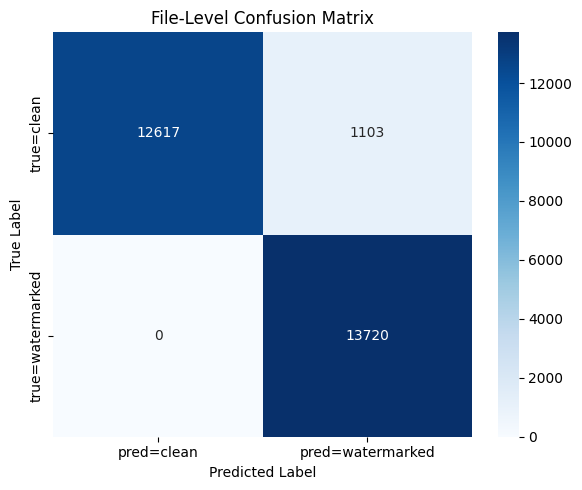


--- Detection Probabilities ---
Clean:      0.1709 ± 0.0699
Watermarked:0.8905 ± 0.0441

ℹ Moderate performance; consider more data or tuning.


In [ ]:
import os
import glob
import random
import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Constants & Configuration ---
SAMPLE_RATE = 16000        # Audio sample rate
AUDIO_LEN   = 16000        # Segment length (1 second)
MESSAGE_BITS = 16          # Number of bits in the hidden message

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# --- Model Loading Utility ---
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    """Loads state_dict, stripping prefix if present (often added by torch.compile)."""
    new_state_dict = {}
    has_prefix = any(key.startswith(prefix) for key in state_dict.keys())
    if has_prefix:
        print(f"Stripping prefix '{prefix}' from state_dict keys.")
        for key, value in state_dict.items():
            if key.startswith(prefix):
                new_key = key[len(prefix):]
                new_state_dict[new_key] = value
            else:
                print(f"Warning: Key '{key}' does not have prefix '{prefix}'. Keeping original key.")
                new_state_dict[key] = value
        missing, unexpected = model.load_state_dict(new_state_dict, strict=False)
        if missing:
            print("Warning: Missing keys while loading stripped state_dict:", missing)
        if unexpected:
            print("Warning: Unexpected keys while loading stripped state_dict:", unexpected)
            print("Attempting fallback to original state_dict...")
            model.load_state_dict(state_dict, strict=False)
    else:
        print("No prefix found, loading state_dict directly.")
        model.load_state_dict(state_dict)

# --- SI-SNR Computation ---
def compute_si_snr(s, s_hat, eps=1e-8):
    """
    Scale-Invariant Signal-to-Noise Ratio (SI-SNR)
    Expects s and s_hat of shape (1, 1, T)
    Returns average SI-SNR in dB.
    """
    # remove batch & channel dims
    x = s.squeeze(0)
    x_hat = s_hat.squeeze(0)
    x = x - x.mean(dim=-1, keepdim=True)
    x_hat = x_hat - x_hat.mean(dim=-1, keepdim=True)
    dot = torch.sum(x * x_hat, dim=-1, keepdim=True)
    norm = torch.sum(x ** 2, dim=-1, keepdim=True)
    alpha = dot / (norm + eps)
    x_target = alpha * x
    e_noise = x_hat - x_target
    si_snr = 10 * torch.log10(torch.sum(x_target ** 2, dim=-1) / (torch.sum(e_noise ** 2, dim=-1) + eps))
    return si_snr.mean().item()

# --- Evaluation for a Single File ---
def evaluate_unseen_file(filepath, generator, detector, device):
    """
    Processes an audio file in 1-second segments, embedding a random watermark and detecting it.
    Returns:
      avg_clean_prob: float
      avg_watermarked_prob: float
      avg_si_snr: float
      avg_rms: float
      clean_labels_list, clean_preds_list, wm_labels_list, wm_preds_list: lists of ints
    """
    try:
        waveform, sr = torchaudio.load(filepath)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, None, None, None, [], [], [], []

    # mono and resample
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
    waveform = waveform.to(device)
    total_samples = waveform.shape[1]

    clean_probs = []
    wm_probs    = []
    si_list     = []
    rms_list    = []
    clean_labels_list = []
    clean_preds_list  = []
    wm_labels_list    = []
    wm_preds_list     = []

    generator.eval()
    detector.eval()
    with torch.no_grad():
        for i in range(0, total_samples, AUDIO_LEN):
            seg = waveform[:, i:i+AUDIO_LEN]
            if seg.shape[1] < AUDIO_LEN:
                seg = F.pad(seg, (0, AUDIO_LEN - seg.shape[1]))
            seg = seg.unsqueeze(0)  # shape (1,1,T)

            # embed watermark
            message = torch.randint(0, 2 ** MESSAGE_BITS, (1,), device=device)
            delta = generator(seg, message)
            seg_w = seg + delta

            # detection logits
            log_clean = detector(seg)[:, :, 0]
            log_wm    = detector(seg_w)[:, :, 0]
            p_clean = torch.sigmoid(log_clean).mean().item()
            p_wm    = torch.sigmoid(log_wm).mean().item()

            clean_probs.append(p_clean)
            wm_probs.append(p_wm)

            # RMS of delta
            rms_val = torch.sqrt((delta ** 2).mean()).item()
            rms_list.append(rms_val)

            # SI-SNR
            si_val = compute_si_snr(seg, seg_w)
            si_list.append(si_val)

            # predictions
            pred_clean = 1 if p_clean >= 0.5 else 0
            pred_wm    = 1 if p_wm    >= 0.5 else 0
            clean_labels_list.append(0)
            clean_preds_list.append(pred_clean)
            wm_labels_list.append(1)
            wm_preds_list.append(pred_wm)

    # averages
    avg_clean_prob      = np.mean(clean_probs)
    avg_watermarked_prob= np.mean(wm_probs)
    avg_si_snr          = np.mean(si_list)
    avg_rms             = np.mean(rms_list)

    return (
        avg_clean_prob,
        avg_watermarked_prob,
        avg_si_snr,
        avg_rms,
        clean_labels_list,
        clean_preds_list,
        wm_labels_list,
        wm_preds_list
    )

# --- Main Execution ---
if __name__ == "__main__":
    set_seed(42)

    UNSEEN_DATA_DIR   = "Songs"
    GENERATOR_WEIGHTS = "generator_best.pth"
    DETECTOR_WEIGHTS  = "detector_best.pth"
    AUDIO_EXTENSIONS  = ['.wav', '.mp3', '.flac', '.ogg']

    # checks
    if not os.path.isdir(UNSEEN_DATA_DIR):
        raise FileNotFoundError(f"Directory not found: {UNSEEN_DATA_DIR}")
    if not os.path.exists(GENERATOR_WEIGHTS):
        raise FileNotFoundError(f"Generator weights not found: {GENERATOR_WEIGHTS}")
    if not os.path.exists(DETECTOR_WEIGHTS):
        raise FileNotFoundError(f"Detector weights not found: {DETECTOR_WEIGHTS}")

    # load models
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Loading models...")
    generator = Generator(message_bits=MESSAGE_BITS).to(device)
    detector  = Detector(message_bits=MESSAGE_BITS).to(device)
    load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device))
    load_state_dict_strip_prefix(detector,  torch.load(DETECTOR_WEIGHTS,  map_location=device))
    generator.eval()
    detector.eval()

    # gather files
    all_files = []
    for ext in AUDIO_EXTENSIONS:
        all_files.extend(glob.glob(os.path.join(UNSEEN_DATA_DIR, '**', f'*{ext}'), recursive=True))
    if not all_files:
        raise RuntimeError(f"No audio files found in {UNSEEN_DATA_DIR}")
    print(f"Found {len(all_files)} files. Beginning evaluation...")

    # storage
    all_clean_probs       = []
    all_watermarked_probs = []
    all_si               = []
    all_rms              = []
    all_clean_gt         = []
    all_clean_pred       = []
    all_wm_gt            = []
    all_wm_pred          = []

    # evaluate
    for filepath in tqdm(all_files, desc="Evaluating Unseen Files"):
        (c, w, si, rms,
         cl_gt, cl_pr,
         wm_gt, wm_pr) = evaluate_unseen_file(filepath, generator, detector, device)
        if c is None:
            continue
        all_clean_probs.append(c)
        all_watermarked_probs.append(w)
        all_si.append(si)
        all_rms.append(rms)
        all_clean_gt.extend(cl_gt)
        all_clean_pred.extend(cl_pr)
        all_wm_gt.extend(wm_gt)
        all_wm_pred.extend(wm_pr)

    # metrics
    avg_clean       = np.mean(all_clean_probs)
    avg_watermarked = np.mean(all_watermarked_probs)
    std_clean       = np.std(all_clean_probs)
    std_watermarked = np.std(all_watermarked_probs)
    avg_si_snr      = np.mean(all_si)
    avg_rms         = np.mean(all_rms)

    print(f"\nAvg SI‑SNR (dB):       {avg_si_snr:.2f}")
    print(f"Avg Watermark RMS:     {avg_rms:.6f}\n")

    # classification and confusion
    y_true = all_clean_gt + all_wm_gt
    y_pred = all_clean_pred + all_wm_pred

    print("--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=["clean", "watermarked"]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["pred=clean","pred=watermarked"],
                yticklabels=["true=clean","true=watermarked"])
    plt.title("File‑Level Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    print("\n--- Detection Probabilities ---")
    print(f"Clean:      {avg_clean:.4f} ± {std_clean:.4f}")
    print(f"Watermarked:{avg_watermarked:.4f} ± {std_watermarked:.4f}\n")

    # interpretation
    if avg_clean < 0.1 and avg_watermarked > 0.9:
        print("✔ Excellent generalization: clean vs. watermarked clearly separated.")
    elif avg_clean > 0.2:
        print(f"⚠ High false positives on clean audio ({avg_clean:.2f}).")
    elif avg_watermarked < 0.8:
        print(f"⚠ Low detection on watermarked audio ({avg_watermarked:.2f}).")
    else:
        print("ℹ Moderate performance; consider more data or tuning.")
